# Notebook Structure

1. Problem Statement and Data Description
2. Loading Datasets and Libraries
3. Understanding and Validating the Data
4. Data Exploration - Train, Product, Store 

# 1. Problem Statement and Data Description

**Problem Statement:** 
Prevent overstocking and understocking of Items by forecasting demand of items for the next week, based on historical data.


<img src = 'retail-shopping-business-wallpaper-preview.jpg' width = 500 height = 500>

**Data Description:**

Train Data- 
- **WEEK_END_DATE** - week ending date
- **STORE_NUM** - store number
- **UPC** - (Universal Product Code) product specific identifier
- **BASE_PRICE** - base price of item
- **DISPLAY** - product was a part of in-store promotional display
- **FEATURE** - product was in in-store circular
- **UNITS** - units sold (target)

Product Data-
- **UPC** - (Universal Product Code) product specific identifier
- **DESCRIPTION**	- product description
- **MANUFACTURER** - product	manufacturer
- **CATEGORY** - category of product
- **SUB_CATEGORY** - sub-category of product
- **PRODUCT_SIZE** - package size or quantity of product

Store Data-
- **STORE_ID** - store number
- **STORE_NAME** - Name of store
- **ADDRESS_CITY_NAME** - city
- **ADDRESS_STATE_PROV_CODE** - state
- **MSA_CODE** - (Metropolitan Statistical Area) Based on geographic region and population density
- **SEG_VALUE_NAME** - Store Segment Name
- **PARKING_SPACE_QTY** - number of parking spaces in the store parking lot
- **SALES_AREA_SIZE_NUM** - square footage of store
- **AVG_WEEKLY_BASKETS** - average weekly baskets sold in the store

# 2. Loading Required Libraries and Datasets

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import random

sns.set_context('notebook',font_scale=1.5)

import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

We are provided with three tables containing the required information:

- **product_data**: Consists of details about the product
- **store_data**: Consists of details of various stores associated with the retailer  
- **train**: Contains transaction data of products

In [2]:
# reading the data files
train = pd.read_csv('train.csv')
product_data = pd.read_csv('product_data.csv')
store_data = pd.read_csv('store_data.csv')

In [3]:
# checking the size of the dataframes
train.shape, product_data.shape, store_data.shape

((232287, 8), (30, 6), (76, 9))

# 3. Understanding and Validating Data

### Train Data

In [4]:
# printing first 5 rows of the train file
train.head()

WEEK_END_DATE  STORE_NUM         UPC  PRICE  BASE_PRICE  FEATURE  DISPLAY  \
0     14-Jan-09        367  1111009477   1.39        1.57        0        0   
1     14-Jan-09        367  1111009497   1.39        1.39        0        0   
2     14-Jan-09        367  1111085319   1.88        1.88        0        0   
3     14-Jan-09        367  1111085345   1.88        1.88        0        0   
4     14-Jan-09        367  1111085350   1.98        1.98        0        0   

   UNITS  
0     13  
1     20  
2     14  
3     29  
4     35

In [5]:
# checking datatypes of columns in train file 
train.dtypes

WEEK_END_DATE     object
STORE_NUM          int64
UPC                int64
PRICE            float64
BASE_PRICE       float64
FEATURE            int64
DISPLAY            int64
UNITS              int64
dtype: object

- WEEK_END_DATE has the data type object, but its a datetime variable 
- The store number and product codes are read as int, but these are categorical variables.

#### Datetime variable 

- The data is captured for what duration?
- What are the start and end dates?
- Is there any missing data points?

#### Numerical Variables

- Check the distribution of numerical variables
- Are there any extreme values?
- Are there any missing values in the variables?

#### Categorical Variables

- Check the unique values for categorical variables
- Are there any missing values in the variables?
- Is there any variable with high cardinality/ sparsity?


##### WEEK_END_DATE


In [6]:
# convert into the date time format
train['WEEK_END_DATE'] = pd.to_datetime(train['WEEK_END_DATE'])

In [7]:
train['WEEK_END_DATE'].isnull().sum()

0

In [8]:
train['WEEK_END_DATE'].min(), train['WEEK_END_DATE'].max()

(Timestamp('2009-01-14 00:00:00'), Timestamp('2011-09-28 00:00:00'))

- The data collected is from January 2009 to September 2011.

#### Are any dates missing from this period?

In [9]:
(train['WEEK_END_DATE'].max() - train['WEEK_END_DATE'].min())/7

Timedelta('141 days 00:00:00')

In [10]:
train['WEEK_END_DATE'].nunique()

142

- The training data is for 142 weeks, based on the number of unique *weekend dates* in the train file. 
- No dates are missing from this period.

#### Are all dates at a gap of a week?

In [11]:
train['WEEK_END_DATE'].dt.day_name().value_counts()

Wednesday    232287
Name: WEEK_END_DATE, dtype: int64

In [12]:
train['WEEK_END_DATE'].dt.day_name().value_counts()

Wednesday    232287
Name: WEEK_END_DATE, dtype: int64

##### STORE_NUM  and UPC

In [13]:
train[['STORE_NUM', 'UPC']].isnull().sum()

STORE_NUM    0
UPC          0
dtype: int64

In [14]:
train['STORE_NUM'].nunique()

76

In [15]:
(train['STORE_NUM'].value_counts()).sort_values()

8035     1676
23055    1823
2523     1977
11967    2104
15755    2253
         ... 
2277     3824
21237    3950
9825     3955
24991    3967
2513     4098
Name: STORE_NUM, Length: 76, dtype: int64

- We have 76 unique stores.
- Every store has minimum of 1676 transactions.

#### Does each store hold atleast one entry per week?

We have 76 unique stores and 142 weeks of data for the sales. If each store is selling occupies atleast one row in the data, the minimum number of unique rows should be 142*76

In [16]:
142*76

10792

In [17]:
train[['WEEK_END_DATE','STORE_NUM']].drop_duplicates().shape

(10792, 2)

- Implies that each store is atleast selling 1 product each week

In [18]:
train['UPC'].nunique()

30

In [19]:
(train['UPC'].value_counts()).sort_values()

3700044982       975
3700031613      1664
31254742835     2086
7797508004      2386
1111038080      2797
7797508006      2933
31254742735     3202
7218063052      3641
7797502248      6916
1111038078      7131
2840004770      7636
1111009507      8067
1111087396      8131
1111087395      8155
2840004768      8488
7192100336      9126
1111087398      9989
1111009477     10356
1111009497     10498
7192100337     10588
1111085319     10636
3800031829     10640
3800039118     10766
7192100339     10767
1111085350     10775
3800031838     10785
1600027564     10786
1600027528     10788
1111085345     10789
1600027527     10790
Name: UPC, dtype: int64


#### Is every product sold atleast once, for all 142 weeks?

In [20]:
142*30

4260

In [21]:
train[['WEEK_END_DATE','UPC']].drop_duplicates().shape

(4260, 2)

- We have 30 unique products in the training data
- There are 76 different stores associated with the retailer
- Both the variables do not have any missing values

#### Is each store selling each product throughout the given period?

Assuming we have information for the sale of every product that is present in the product table (30), against each store associated (76), and for every week (142); we should have 142*76*30 data rows. 

In [22]:
142*76*30

323760

In [23]:
train.shape

(232287, 8)

In [24]:
232286/323760 

0.7174635532493204

- We can conclude that all stores are not selling all products each week
- Of all the possible combinations, about 72% of the data is present

#### For a store selling a particular product, do we have more than one entry?


Each product sold by any store should hold only one row, i.e. a particular store, say 'store A' selling a product 'prod P' should contribute a single row for every week. Let us check that.

In [25]:
train.shape

(232287, 8)

In [26]:
train[['WEEK_END_DATE','STORE_NUM','UPC']].drop_duplicates().shape

(232287, 3)

In [27]:
train.groupby(['WEEK_END_DATE','STORE_NUM'])['UPC'].count().mean()

21.523999258710155

- The shape does not change after using drop duplicates
- Implies that there are unique combinations for week, store and UPC
- On an average, each week we are selling 22 products

#### Is a store selling a product throughout the period or is there a break?

In [28]:
(train.groupby(['STORE_NUM', 'UPC'])['UNITS'].count()).sort_values()

STORE_NUM  UPC       
4489       1111087396    137
19265      7797508006    137
21221      7797508004    137
6187       1111038080    137
23349      2840004768    137
                        ... 
11993      1111085345    142
           1111085319    142
           1111038080    142
           1600027564    142
29159      7797508004    142
Name: UNITS, Length: 1644, dtype: int64

- Not all stores sell a product throughout the week
- The minimum number is 137/142

We now have a basic understanding of the number of products and stores we are dealing with in this data.

##### BASE_PRICE

In [29]:
train['BASE_PRICE'].isnull().sum()

12

In [30]:
train['BASE_PRICE'].describe()

count    232275.000000
mean          3.345204
std           1.678181
min           0.860000
25%           1.950000
50%           2.990000
75%           4.080000
max           7.890000
Name: BASE_PRICE, dtype: float64

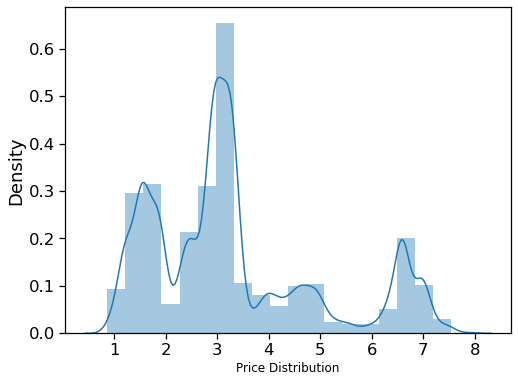

In [31]:
# distribution of Base Price variable
plt.figure(figsize=(8,6))
sns.distplot((train['BASE_PRICE'].values), bins=20, kde=True)
plt.xlabel('Price Distribution', fontsize=12)
plt.show()

- No extreme values in the base price variable
- Range for base price is 1 dollar to 8 dollars

##### FEATURE and DISPLAY

In [32]:
train[['FEATURE','DISPLAY']].isnull().sum()

FEATURE    0
DISPLAY    0
dtype: int64

In [33]:
train[['FEATURE','DISPLAY']].dtypes

FEATURE    int64
DISPLAY    int64
dtype: object

In [34]:
train[['FEATURE','DISPLAY']].nunique()

FEATURE    2
DISPLAY    2
dtype: int64

In [35]:
train['FEATURE'].value_counts(normalize=True)

0    0.900111
1    0.099889
Name: FEATURE, dtype: float64

<AxesSubplot:>

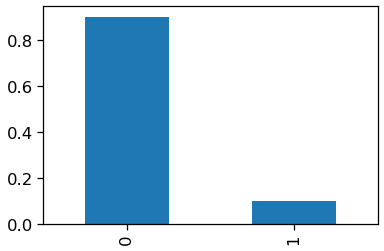

In [36]:
train['FEATURE'].value_counts(normalize=True).plot(kind='bar')

- Approximately 10 percent of product are featured

In [37]:
train['DISPLAY'].value_counts(normalize=True)

0    0.864999
1    0.135001
Name: DISPLAY, dtype: float64

<AxesSubplot:>

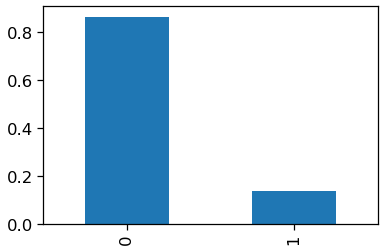

In [38]:
train['DISPLAY'].value_counts(normalize=True).plot(kind='bar')

- About 13% of products are on display

In [39]:
pd.crosstab(train['FEATURE'], train['DISPLAY']).apply(lambda r: r/len(train), axis=1)

DISPLAY         0         1
FEATURE                    
0        0.821824  0.078287
1        0.043175  0.056714

##### UNITS

In [40]:
train['UNITS'].isnull().sum()

0

In [41]:
# basic statistical details of UNITS variable
train['UNITS'].describe()

count    232287.000000
mean         28.063525
std          35.954341
min           0.000000
25%           9.000000
50%          18.000000
75%          34.000000
max        1800.000000
Name: UNITS, dtype: float64

- The Range of values is very high
- Minimum number of units sold is 0 and maximum is 1800
- A huge difference between the 75th percentile and the max value indicates presence of outliers

#### How many rows in the data have 0 units sold?
#### Is there only one row with such high sales of 1800? 

In [42]:
train[train['UNITS'] == 0]

WEEK_END_DATE  STORE_NUM          UPC  PRICE  BASE_PRICE  FEATURE  \
76752    2009-12-02      28909  31254742735    NaN        4.99        0   

       DISPLAY  UNITS  
76752        0      0

- Only one entry with 0 items sold
- Indicates the given store does not sell the following item
- It's simply a Data Anomaly and will not be useful in model training

In [43]:
# keeping rows with UNITS sold not equal to zero
train = train[train['UNITS'] != 0]

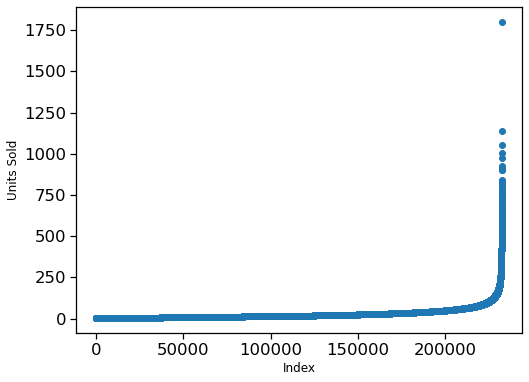

In [44]:
# scatter plot for UNITS variable
plt.figure(figsize=(8,6))
plt.scatter(x = range(train.shape[0]), y = np.sort(train['UNITS'].values))
plt.xlabel('Index', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.show()

- Most of the values are less than 250 
- There are a few outliers (with 1 outlier way outside the range)

In [45]:
train[train['UNITS'] > 1000]

WEEK_END_DATE  STORE_NUM         UPC  PRICE  BASE_PRICE  FEATURE  \
7893     2009-02-11      24991  1600027527   1.67        3.19        1   
7960     2009-02-11      25027  1600027527   1.64        3.19        1   
9597     2009-02-18      25027  1600027527   1.60        3.19        0   
11209    2009-02-25      25027  1600027527   1.64        3.19        1   

       DISPLAY  UNITS  
7893         0   1006  
7960         1   1800  
9597         1   1054  
11209        1   1136

To reduce the effect of outliers and for better visualization, here is a log transform of the variable


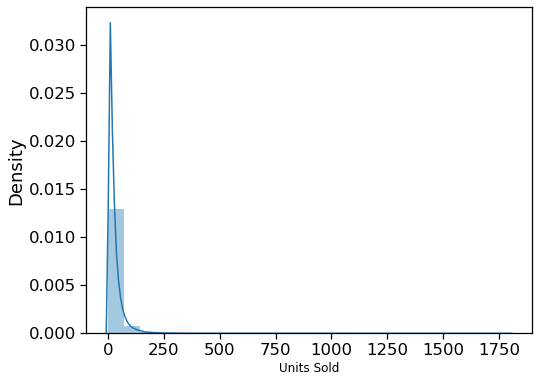

In [46]:
# distribution of UNITS variable
plt.figure(figsize=(8,6))
sns.distplot((train['UNITS'].values), bins=25, kde=True)
plt.xlabel('Units Sold', fontsize=12)
plt.show()

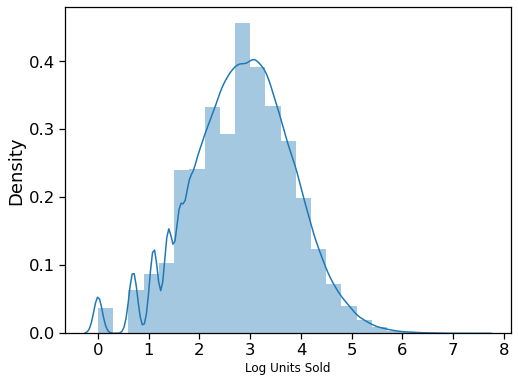

In [47]:
# log transformed UNITS column
plt.figure(figsize=(8,6))
sns.distplot(np.log(train['UNITS'].values), bins=25, kde=True)
plt.xlabel('Log Units Sold', fontsize=12)
plt.show()

- After log transformation, the distribution looks closer to a normal distribution

### Understanding Product Data

In [48]:
# first five rows of product data
product_data.head()

UPC               DESCRIPTION   MANUFACTURER               CATEGORY  \
0  1111009477    PL MINI TWIST PRETZELS  PRIVATE LABEL             BAG SNACKS   
1  1111009497         PL PRETZEL STICKS  PRIVATE LABEL             BAG SNACKS   
2  1111009507         PL TWIST PRETZELS  PRIVATE LABEL             BAG SNACKS   
3  1111038078  PL BL MINT ANTSPTC RINSE  PRIVATE LABEL  ORAL HYGIENE PRODUCTS   
4  1111038080  PL ANTSPTC SPG MNT MTHWS  PRIVATE LABEL  ORAL HYGIENE PRODUCTS   

               SUB_CATEGORY PRODUCT_SIZE  
0                  PRETZELS        15 OZ  
1                  PRETZELS        15 OZ  
2                  PRETZELS        15 OZ  
3  MOUTHWASHES (ANTISEPTIC)       500 ML  
4  MOUTHWASHES (ANTISEPTIC)       500 ML

In [49]:
product_data.dtypes

UPC              int64
DESCRIPTION     object
MANUFACTURER    object
CATEGORY        object
SUB_CATEGORY    object
PRODUCT_SIZE    object
dtype: object

#### Categorical Variables

- Check the unique values for categorical variables
- Are there any missing values in the variables?
- Is there any variable with high cardinality/ sparsity?

##### UPC 

In [50]:
product_data['UPC'].nunique()

30

- The number is consistent through the train and product data.
##### Are all the product codes exactly the same?

In [51]:
len(set(product_data.UPC).intersection(set(train.UPC)))

30

##### CATEGORY

In [52]:
# number and list of unique categories in the product data
product_data['CATEGORY'].nunique(), product_data['CATEGORY'].unique()

(4,
 array(['BAG SNACKS', 'ORAL HYGIENE PRODUCTS', 'COLD CEREAL',
        'FROZEN PIZZA'], dtype=object))

In [53]:
product_data['CATEGORY'].isnull().sum()

0

In [54]:
product_data['CATEGORY'].value_counts()

COLD CEREAL              9
BAG SNACKS               8
FROZEN PIZZA             7
ORAL HYGIENE PRODUCTS    6
Name: CATEGORY, dtype: int64

- We have four product categories - 
  *  BAG SNACKS
  *  ORAL HYGIENE PRODUCTS 
  *  COLD CEREAL 
  *  FROZEN PIZZA

- There are 9 products with the category 'Cold Cereal'
- Similarly, 8 products labeled 'Bag snacks', 7 with category 'Frozen Pizza' and 6 'Oral Hygiene' Products

#### Is there any subdivision among the product categories?

#####  SUB_CATEGORY 

In [55]:
product_data['SUB_CATEGORY'].isnull().sum()

0

In [56]:
product_data['SUB_CATEGORY'].nunique()

7

In [57]:
# displaying subcategories against each category
product_data[['CATEGORY','SUB_CATEGORY']].drop_duplicates().sort_values(by = 'CATEGORY')

CATEGORY                 SUB_CATEGORY
0              BAG SNACKS                     PRETZELS
5             COLD CEREAL            ALL FAMILY CEREAL
6             COLD CEREAL                 ADULT CEREAL
19            COLD CEREAL                  KIDS CEREAL
8            FROZEN PIZZA                PIZZA/PREMIUM
3   ORAL HYGIENE PRODUCTS     MOUTHWASHES (ANTISEPTIC)
16  ORAL HYGIENE PRODUCTS  MOUTHWASH/RINSES AND SPRAYS

The sub-categories give additional detail about the product.

- Cereal has 3 sub categories, differentiating on the age group 
- Oral hygiene products have 2 sub categories, antiseptic and rinse/spray
- Bag Snacks & Frozen Pizza have just 1 sub category, no further division


#### Does the sub category has anything to do with the size of the product?

#####  	PRODUCT_SIZE

In [58]:
# unique category, sub-category and product size combinations
product_data[['CATEGORY','SUB_CATEGORY','PRODUCT_SIZE']].drop_duplicates().sort_values(by = 'CATEGORY')

CATEGORY                 SUB_CATEGORY PRODUCT_SIZE
0              BAG SNACKS                     PRETZELS        15 OZ
14             BAG SNACKS                     PRETZELS        16 OZ
25             BAG SNACKS                     PRETZELS        10 OZ
6             COLD CEREAL                 ADULT CEREAL        20 OZ
7             COLD CEREAL            ALL FAMILY CEREAL        18 OZ
19            COLD CEREAL                  KIDS CEREAL        15 OZ
20            COLD CEREAL                  KIDS CEREAL      12.2 OZ
5             COLD CEREAL            ALL FAMILY CEREAL     12.25 OZ
13            COLD CEREAL            ALL FAMILY CEREAL        12 OZ
8            FROZEN PIZZA                PIZZA/PREMIUM      32.7 OZ
9            FROZEN PIZZA                PIZZA/PREMIUM      30.5 OZ
10           FROZEN PIZZA                PIZZA/PREMIUM      29.6 OZ
24           FROZEN PIZZA                PIZZA/PREMIUM      22.7 OZ
21           FROZEN PIZZA                PIZZA/PREMIUM      29.8 OZ
23           FROZEN PIZZA                PIZZA/PREMIUM      28.3 OZ
3   ORAL HYGIENE PRODUCTS     MOUTHWASHES (ANTISEPTIC)       500 ML
16  ORAL HYGIENE PRODUCTS  MOUTHWASH/RINSES AND SPRAYS         1 LT
17  ORAL HYGIENE PRODUCTS     MOUTHWASHES (ANTISEPTIC)         1 LT

The cold cereal for kids is available in two different sizes.
Also, the cold cereal for all family has the same size as the cold cereal for kids.
Hence subcategory is not an indicator of size.

**To summarize**
- Bag Snacks has 1 sub category and 3 product size available
- Oral Hygiene product has 2 sub categories and 2 size options
- Frozen Pizza has only 1 sub category and 6 different package size
- cold ceral has 3 sub categoeies, and 6 options in size

##### DESCRIPTION 

In [59]:
product_data['DESCRIPTION'].isnull().sum()

0

In [60]:
# number and list of unique descriptions in the prodcut data
product_data['DESCRIPTION'].nunique(), product_data['DESCRIPTION'].unique()

(29,
 array(['PL MINI TWIST PRETZELS', 'PL PRETZEL STICKS', 'PL TWIST PRETZELS',
        'PL BL MINT ANTSPTC RINSE', 'PL ANTSPTC SPG MNT MTHWS',
        'PL HONEY NUT TOASTD OATS', 'PL RAISIN BRAN',
        'PL BT SZ FRSTD SHRD WHT', 'PL SR CRUST SUPRM PIZZA',
        'PL SR CRUST 3 MEAT PIZZA', 'PL SR CRUST PEPPRN PIZZA',
        'GM HONEY NUT CHEERIOS', 'GM CHEERIOS', 'RLDGLD TINY TWISTS PRTZL',
        'RLDGLD PRETZEL STICKS', 'SCOPE ORIG MINT MOUTHWASH',
        'CREST PH CLN MINT RINSE', 'KELL BITE SIZE MINI WHEAT',
        'KELL FROSTED FLAKES', 'KELL FROOT LOOPS', 'DIGIORNO THREE MEAT',
        'DIGRN SUPREME PIZZA', 'DIGRN PEPP PIZZA',
        'FRSC BRCK OVN ITL PEP PZ', 'SNYDR PRETZEL RODS',
        'SNYDR SOURDOUGH NIBBLERS', 'SNYDR FF MINI PRETZELS',
        'LSTRNE CL MINT ANTSPTC MW', 'LSTRNE FRS BRST ANTSPC MW'],
       dtype=object))

- We have 29 descriptions in the dataset, for 30 products.
- Almost all products have a unique description. 

In [61]:
(product_data['DESCRIPTION'].value_counts())

GM CHEERIOS                  2
SCOPE ORIG MINT MOUTHWASH    1
PL BT SZ FRSTD SHRD WHT      1
PL ANTSPTC SPG MNT MTHWS     1
FRSC BRCK OVN ITL PEP PZ     1
PL SR CRUST SUPRM PIZZA      1
PL PRETZEL STICKS            1
PL RAISIN BRAN               1
SNYDR PRETZEL RODS           1
PL SR CRUST PEPPRN PIZZA     1
GM HONEY NUT CHEERIOS        1
LSTRNE CL MINT ANTSPTC MW    1
PL HONEY NUT TOASTD OATS     1
SNYDR FF MINI PRETZELS       1
PL BL MINT ANTSPTC RINSE     1
PL TWIST PRETZELS            1
CREST PH CLN MINT RINSE      1
KELL FROSTED FLAKES          1
PL SR CRUST 3 MEAT PIZZA     1
KELL BITE SIZE MINI WHEAT    1
LSTRNE FRS BRST ANTSPC MW    1
DIGRN PEPP PIZZA             1
DIGRN SUPREME PIZZA          1
RLDGLD TINY TWISTS PRTZL     1
DIGIORNO THREE MEAT          1
KELL FROOT LOOPS             1
SNYDR SOURDOUGH NIBBLERS     1
RLDGLD PRETZEL STICKS        1
PL MINI TWIST PRETZELS       1
Name: DESCRIPTION, dtype: int64

In [62]:
product_data.loc[product_data['DESCRIPTION']=='GM CHEERIOS']

UPC  DESCRIPTION MANUFACTURER     CATEGORY       SUB_CATEGORY  \
12  1600027528  GM CHEERIOS   GENERAL MI  COLD CEREAL  ALL FAMILY CEREAL   
13  1600027564  GM CHEERIOS   GENERAL MI  COLD CEREAL  ALL FAMILY CEREAL   

   PRODUCT_SIZE  
12        18 OZ  
13        12 OZ

In [63]:
product_data.loc[product_data['UPC'] == 1600027527]

UPC            DESCRIPTION MANUFACTURER     CATEGORY  \
11  1600027527  GM HONEY NUT CHEERIOS   GENERAL MI  COLD CEREAL   

         SUB_CATEGORY PRODUCT_SIZE  
11  ALL FAMILY CEREAL     12.25 OZ

- More granular description for the product
- Includes the type of product and manufacturer

##### MANUFACTURER


#### How many Manufacturers/ suppliers are we associated with?

#### Are same products created by multiple manufacturers?


In [64]:
product_data['MANUFACTURER'].isnull().sum()

0

In [65]:
product_data['MANUFACTURER'].nunique()

9

In [66]:
# displaying the list of manufacturers against the 4 categories
temp = product_data[['CATEGORY','MANUFACTURER']].drop_duplicates()
pd.crosstab([temp['CATEGORY']], temp['MANUFACTURER'])

MANUFACTURER           FRITO LAY  GENERAL MI  KELLOGG  P & G  PRIVATE LABEL  \
CATEGORY                                                                      
BAG SNACKS                     1           0        0      0              1   
COLD CEREAL                    0           1        1      0              1   
FROZEN PIZZA                   0           0        0      0              1   
ORAL HYGIENE PRODUCTS          0           0        0      1              1   

MANUFACTURER           SNYDER S  TOMBSTONE  TONYS  WARNER  
CATEGORY                                                   
BAG SNACKS                    1          0      0       0  
COLD CEREAL                   0          0      0       0  
FROZEN PIZZA                  0          1      1       0  
ORAL HYGIENE PRODUCTS         0          0      0       1

- We have 4 unique categories of Products
- Each category has three manufacturers
- Every category has a manufacturer 'private label' (and 2 other manufacturers)

### Understanding Store Data

In [67]:
store_data.head()

STORE_ID          STORE_NAME ADDRESS_CITY_NAME ADDRESS_STATE_PROV_CODE  \
0       367      15TH & MADISON         COVINGTON                      KY   
1       389          SILVERLAKE          ERLANGER                      KY   
2       613          EAST ALLEN             ALLEN                      TX   
3       623             HOUSTON           HOUSTON                      TX   
4      2277  ANDERSON TOWNE CTR        CINCINNATI                      OH   

   MSA_CODE SEG_VALUE_NAME  PARKING_SPACE_QTY  SALES_AREA_SIZE_NUM  \
0     17140          VALUE              196.0                24721   
1     17140     MAINSTREAM              408.0                46073   
2     19100     MAINSTREAM              464.0                64926   
3     26420     MAINSTREAM                NaN                46930   
4     17140        UPSCALE                NaN                81958   

   AVG_WEEKLY_BASKETS  
0               12707  
1               24767  
2               29386  
3               36741  
4               54053

In [68]:
store_data.dtypes

STORE_ID                     int64
STORE_NAME                  object
ADDRESS_CITY_NAME           object
ADDRESS_STATE_PROV_CODE     object
MSA_CODE                     int64
SEG_VALUE_NAME              object
PARKING_SPACE_QTY          float64
SALES_AREA_SIZE_NUM          int64
AVG_WEEKLY_BASKETS           int64
dtype: object

#### Numerical Variables

- Check the distribution of numerical variables
- Are there any extreme values?
- Are there any missing values in the variables?

#### Categorical Variables

- Check the unique values for categorical variables
- Are there any missing values in the variables?
- Is there any variable with high cardinality/ sparsity?

##### STORE_ID

In [69]:
store_data['STORE_ID'].nunique()

76

In [70]:
len(set(store_data.STORE_ID).intersection(set(train.STORE_NUM)))

76

##### STORE_NAME

In [71]:
store_data['STORE_NAME'].isnull().sum()

0

In [72]:
store_data['STORE_NAME'].nunique()

72

- The number of unique store IDs is more than number of unique store names
- There might be stores with same name, located in different city

#### Which store name is being repeated?

#### Why do some stores have same name and different ID?

In [73]:
# number of store names repeating
store_data['STORE_NAME'].value_counts()

HOUSTON              4
MIDDLETOWN           2
DENTON               1
FRISCO               1
DAYTON               1
                    ..
NORTHBOROUGH SQ      1
DICKINSON VILLAGE    1
MIAMI TOWNSHIP       1
HYDE PARK            1
CYPRESS              1
Name: STORE_NAME, Length: 72, dtype: int64

In [74]:
store_data.loc[store_data['STORE_NAME'] == 'HOUSTON']

STORE_ID STORE_NAME ADDRESS_CITY_NAME ADDRESS_STATE_PROV_CODE  MSA_CODE  \
3        623    HOUSTON           HOUSTON                      TX     26420   
9       2513    HOUSTON           HOUSTON                      TX     26420   
54     21485    HOUSTON              KATY                      TX     26420   
59     23327    HOUSTON           HOUSTON                      TX     26420   

   SEG_VALUE_NAME  PARKING_SPACE_QTY  SALES_AREA_SIZE_NUM  AVG_WEEKLY_BASKETS  
3      MAINSTREAM                NaN                46930               36741  
9         UPSCALE                NaN                61833               32423  
54     MAINSTREAM                NaN                46369               26472  
59     MAINSTREAM                NaN                50722               30258

In [75]:
store_data.loc[store_data['STORE_NAME'] == 'MIDDLETOWN']

STORE_ID  STORE_NAME ADDRESS_CITY_NAME ADDRESS_STATE_PROV_CODE  MSA_CODE  \
50     21221  MIDDLETOWN        MIDDLETOWN                      OH     17140   
74     28909  MIDDLETOWN        MIDDLETOWN                      OH     17140   

   SEG_VALUE_NAME  PARKING_SPACE_QTY  SALES_AREA_SIZE_NUM  AVG_WEEKLY_BASKETS  
50          VALUE                NaN                48128               17010  
74     MAINSTREAM                NaN                85876               28986

The store names that are repeated, are actually different stores which either have a different city or different segment (upscale, mainstream, value) or  location. Hence they are given a different IDs. 

##### ADDRESS_CITY_NAME  and ADDRESS_STATE_PROV_CODE

In [76]:
store_data[['ADDRESS_STATE_PROV_CODE', 'ADDRESS_CITY_NAME']].isnull().sum()

ADDRESS_STATE_PROV_CODE    0
ADDRESS_CITY_NAME          0
dtype: int64

#### How many cities and states are the stores located in?

In [77]:
store_data[['ADDRESS_STATE_PROV_CODE', 'ADDRESS_CITY_NAME']].nunique()

ADDRESS_STATE_PROV_CODE     4
ADDRESS_CITY_NAME          51
dtype: int64

<img src = 'texas-to-ohio-map-map-of-arizona-and-california-cities-california-map-major-cities-of-texas-to-ohio-map.jpg' width = 700 height = 700>

Let's find out the number of stores in each of the state 

In [78]:
store_data.groupby(['ADDRESS_STATE_PROV_CODE'])['STORE_ID'].count()

ADDRESS_STATE_PROV_CODE
IN     1
KY     4
OH    30
TX    41
Name: STORE_ID, dtype: int64

- Each store has a unique store ID 
- Most stores are from Ohio and Texas ~93%
- Few from Kentucky and Indiana ~7%

In [79]:
store_data.groupby(['ADDRESS_STATE_PROV_CODE'])['ADDRESS_CITY_NAME'].nunique()

ADDRESS_STATE_PROV_CODE
IN     1
KY     3
OH    16
TX    31
Name: ADDRESS_CITY_NAME, dtype: int64

In [80]:
store_data['ADDRESS_CITY_NAME'].value_counts()

CINCINNATI         9
HOUSTON            8
MIDDLETOWN         3
DAYTON             2
LOVELAND           2
HAMILTON           2
COVINGTON          2
MAINEVILLE         2
MCKINNEY           2
SUGAR LAND         2
KATY               2
GOSHEN             1
DENTON             1
CROWLEY            1
WOODLANDS          1
BLUE ASH           1
MESQUITE           1
DICKINSON          1
BEAUMONT           1
INDEPENDENCE       1
SPRINGFIELD        1
MAGNOLIA           1
VANDALIA           1
DUNCANVILLE        1
DALLAS             1
MILFORD            1
SAINT MARYS        1
GRAND PRAIRIE      1
FRISCO             1
WEST CHESTER       1
LEBANON            1
ROCKWALL           1
COLLEGE STATION    1
ERLANGER           1
KINGWOOD           1
SOUTHLAKE          1
ARLINGTON          1
LAWRENCEBURG       1
MASON              1
PASADENA           1
BAYTOWN            1
SHERMAN            1
CARROLLTON         1
GARLAND            1
CYPRESS            1
KETTERING          1
THE WOODLANDS      1
FLOWER MOUND 

##### MSA_CODE

In [81]:
store_data['MSA_CODE'].isnull().sum()

0

In [82]:
store_data['MSA_CODE'].nunique(), store_data['MSA_CODE'].unique()

(9,
 array([17140, 19100, 26420, 17780, 47540, 43300, 19380, 13140, 44220],
       dtype=int64))

In [83]:
store_data['MSA_CODE'].value_counts()

17140    29
26420    21
19100    17
19380     4
17780     1
47540     1
43300     1
44220     1
13140     1
Name: MSA_CODE, dtype: int64

In [84]:
(store_data.groupby(['MSA_CODE', 'ADDRESS_STATE_PROV_CODE'])['STORE_ID'].count())

MSA_CODE  ADDRESS_STATE_PROV_CODE
13140     TX                          1
17140     IN                          1
          KY                          4
          OH                         24
17780     TX                          1
19100     TX                         17
19380     OH                          4
26420     TX                         21
43300     TX                          1
44220     OH                          1
47540     OH                          1
Name: STORE_ID, dtype: int64

- These codes are assigned based on the geographical location and population density. 
- 17140 is present in all three except Texas (which has a different geographical region)

##### PARKING_SPACE_QTY  and SALES_AREA_SIZE_NUM 

In [85]:
store_data[['PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM']].isnull().sum()

PARKING_SPACE_QTY      51
SALES_AREA_SIZE_NUM     0
dtype: int64

- Of 76 stores, parking area of 51 is missing

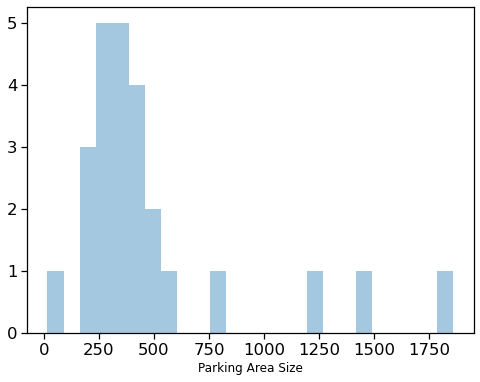

In [86]:
plt.figure(figsize=(8,6))
sns.distplot(store_data['PARKING_SPACE_QTY'], bins=25, kde=False)
plt.xlabel('Parking Area Size', fontsize=12)
plt.show()

- About 15 stores have parking area between 250 - 500 units

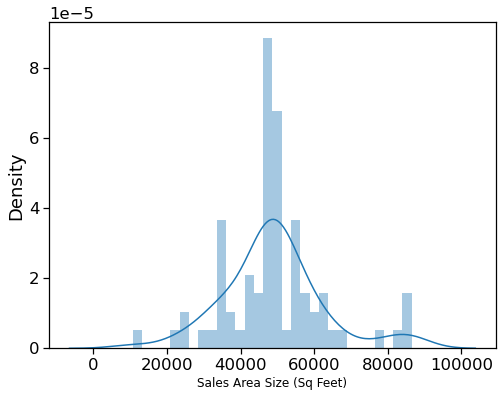

In [87]:
plt.figure(figsize=(8,6))
sns.distplot(store_data['SALES_AREA_SIZE_NUM'], bins=30, kde=True)
plt.xlabel('Sales Area Size (Sq Feet)', fontsize=12)
plt.show()

- Most stores have the area between 30-70 K
- Only a small number of stores have area less than 30k or greater than 90k

#### How is Average store size varying for different states?

In [88]:
(store_data.groupby(['ADDRESS_STATE_PROV_CODE'])['SALES_AREA_SIZE_NUM'].mean()).sort_values(ascending=False)

ADDRESS_STATE_PROV_CODE
IN    58563.000000
OH    52691.200000
TX    46920.902439
KY    39855.500000
Name: SALES_AREA_SIZE_NUM, dtype: float64

<AxesSubplot:xlabel='SALES_AREA_SIZE_NUM', ylabel='Density'>

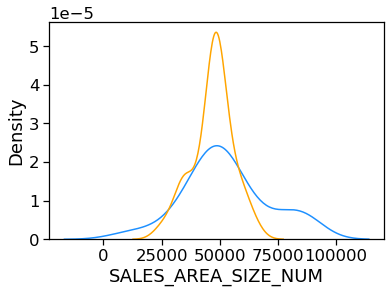

In [89]:
state_oh = store_data.loc[store_data['ADDRESS_STATE_PROV_CODE'] == 'OH']
state_tx = store_data.loc[store_data['ADDRESS_STATE_PROV_CODE'] == 'TX']

sns.distplot(state_oh['SALES_AREA_SIZE_NUM'], hist=False,color= 'dodgerblue', label= 'OHIO')
sns.distplot(state_tx['SALES_AREA_SIZE_NUM'], hist=False,  color= 'orange', label= 'TEXAS')


- Indiana has only one store and the area size is 58,563 sq feet. 
- Ohio and Texas have average around 52k and 50k. 
- Ohio has stores distributed at all sizes.
- Texas mainly has stores between sales area 30k to 60k 

##### AVG_WEEKLY_BASKETS

In [90]:
store_data['AVG_WEEKLY_BASKETS'].isnull().sum()

0

In [91]:
store_data['AVG_WEEKLY_BASKETS'].describe()

count       76.000000
mean     24226.921053
std       8863.939362
min      10435.000000
25%      16983.500000
50%      24667.500000
75%      29398.500000
max      54053.000000
Name: AVG_WEEKLY_BASKETS, dtype: float64

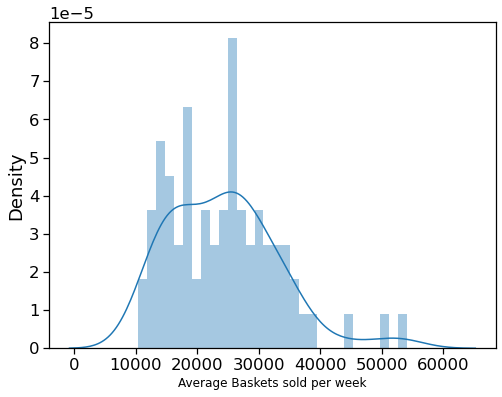

In [92]:
plt.figure(figsize=(8,6))
sns.distplot(store_data['AVG_WEEKLY_BASKETS'], bins=30, kde=True)
plt.xlabel('Average Baskets sold per week', fontsize=12)
plt.show()

#### What are the average weekly baskets sold for the states? 

In [93]:
(store_data.groupby(['ADDRESS_STATE_PROV_CODE'])['AVG_WEEKLY_BASKETS'].mean()).sort_values(ascending=False)

ADDRESS_STATE_PROV_CODE
OH    26113.766667
TX    23234.195122
KY    21489.000000
IN    19275.000000
Name: AVG_WEEKLY_BASKETS, dtype: float64

##### SEG_VALUE_NAME

In [94]:
store_data['SEG_VALUE_NAME'].isnull().sum()

0

There are certain segments assigned to store, based on the brand and quality of products sold at the store.

- **Upscale stores** : Located in high income neighborhoods and offer more high-end product
- **Mainstream stores** : Located in middle class areas, offering a mix of upscale and value product
- **Value stores** : Focus on low prices products targeting low income customers

Let us look at the distribution of stores in each of these segments

In [95]:
store_data['SEG_VALUE_NAME'].value_counts()

MAINSTREAM    43
VALUE         19
UPSCALE       14
Name: SEG_VALUE_NAME, dtype: int64

#### Does the segment has any relation with the store area?

#### Is there a difference in the average sales for each segment?

In [96]:
(store_data.groupby(['SEG_VALUE_NAME'])['SALES_AREA_SIZE_NUM'].mean()).sort_values(ascending=False)

SEG_VALUE_NAME
UPSCALE       59556.428571
MAINSTREAM    50075.976744
VALUE         38706.368421
Name: SALES_AREA_SIZE_NUM, dtype: float64

In [97]:
(store_data.groupby(['SEG_VALUE_NAME'])['AVG_WEEKLY_BASKETS'].mean()).sort_values(ascending=False)

SEG_VALUE_NAME
UPSCALE       28735.928571
MAINSTREAM    24024.093023
VALUE         21363.526316
Name: AVG_WEEKLY_BASKETS, dtype: float64

# 4. Data Exploration - Train, Product, Store

## Validating the Hypothesis

During the Hypothesis Generation, we listed down the following hypothesis. 

**Product Data**
- Product type/ Category : Different Product Categories can have significantly varying trends/patterns
- Product Size : Larger products should be more in demand 
- Price of Product: Same category products with lower price would have more sales
- Company/ Manufacturer: Well known brands/manufacturers will have higher sales

**Train Data**

- Offer Applicable: Featured Products with attractive offers will have higher sales
- Product Promotion: Sales will be more for products with in-store promotion

**Store Data**
- Store Location: Stores in a particular state/city will have a similar trend
- Size of Store: Stores with larger area would have more sales
- Average Wait time: If average baskets sold is higher, wait time would be low. Implies higher sale of units. 

### Merging the Store and Product Datasets

In [98]:
store_product_data = train.merge(product_data, how = 'left', on='UPC')

store_product_data = store_product_data.merge(store_data, how = 'left', left_on = 'STORE_NUM', right_on = 'STORE_ID')

In [99]:
store_product_data.shape

(232286, 22)

In [100]:
store_product_data.columns

Index(['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'PRICE', 'BASE_PRICE', 'FEATURE',
       'DISPLAY', 'UNITS', 'DESCRIPTION', 'MANUFACTURER', 'CATEGORY',
       'SUB_CATEGORY', 'PRODUCT_SIZE', 'STORE_ID', 'STORE_NAME',
       'ADDRESS_CITY_NAME', 'ADDRESS_STATE_PROV_CODE', 'MSA_CODE',
       'SEG_VALUE_NAME', 'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM',
       'AVG_WEEKLY_BASKETS'],
      dtype='object')

### Trend or Seasonal Pattern in Product Sales

- Product type/Category: Different Product Categories can have significantly varying trends/patterns


### Units sold per week

<AxesSubplot:xlabel='WEEK_END_DATE', ylabel='UNITS'>

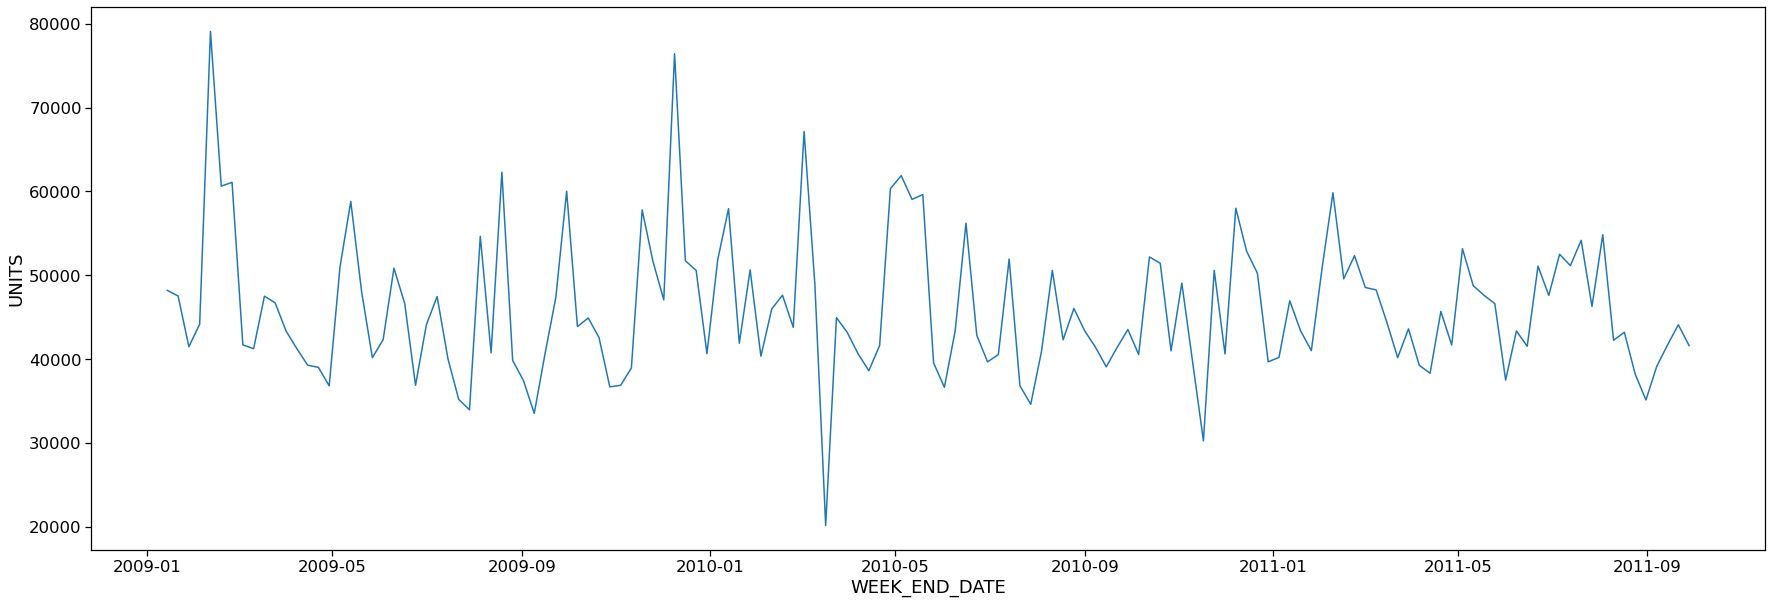

In [101]:
#sum of units sold per week
weekly_demand = store_product_data.groupby(['WEEK_END_DATE'])['UNITS'].sum()

plt.figure(figsize=(30,10))
sns.lineplot(x = weekly_demand.index, y = weekly_demand)

- Displays the total number of units sold by the retailer (including all products and from all stores)
- The highest number is close to 80,000 and lowest is close to 20,000 units
- There is no evident pattern or trend in the plot
- The spikes can be seen in either direction and at no constant interval

### Units sold per week - at product level

Now, we will look at category wise sales or demand patterns to see if there is any similarity within each category

In [102]:
# function to plot weekly sales of products
def product_plots(product_list):
    
    # dictionary storing UPC and weekly sales
    d = {product: store_product_data[store_product_data['UPC'] == product].groupby(['WEEK_END_DATE'])['UNITS'].sum() for product in product_list}
    fig, axs = plt.subplots(len(product_list), 1, figsize = (20, 20), dpi=300)
    j = 0
    
    for product in d.keys():
        # adding manufacturer and descritption in title
        manu = product_data[product_data['UPC'] == product]['MANUFACTURER'].values[0]
        desc = product_data[product_data['UPC'] == product]['DESCRIPTION'].values[0]            
        # creating the plot
        sns.lineplot(x = d[product].index, y = d[product],ax = axs[j]).set_title(str(manu)+str(" ")+str(desc), y=0.75, fontsize = 16)
        j = j+1
    plt.tight_layout()

In [103]:
# creating list of products based on category
pretzels = list(product_data[product_data['CATEGORY'] == 'BAG SNACKS']['UPC'])
frozen_pizza = list(product_data[product_data['CATEGORY'] == 'FROZEN PIZZA']['UPC'])
oral_hygiene = list(product_data[product_data['CATEGORY'] == 'ORAL HYGIENE PRODUCTS']['UPC'])
cold_cereal = list(product_data[product_data['CATEGORY'] == 'COLD CEREAL']['UPC'])

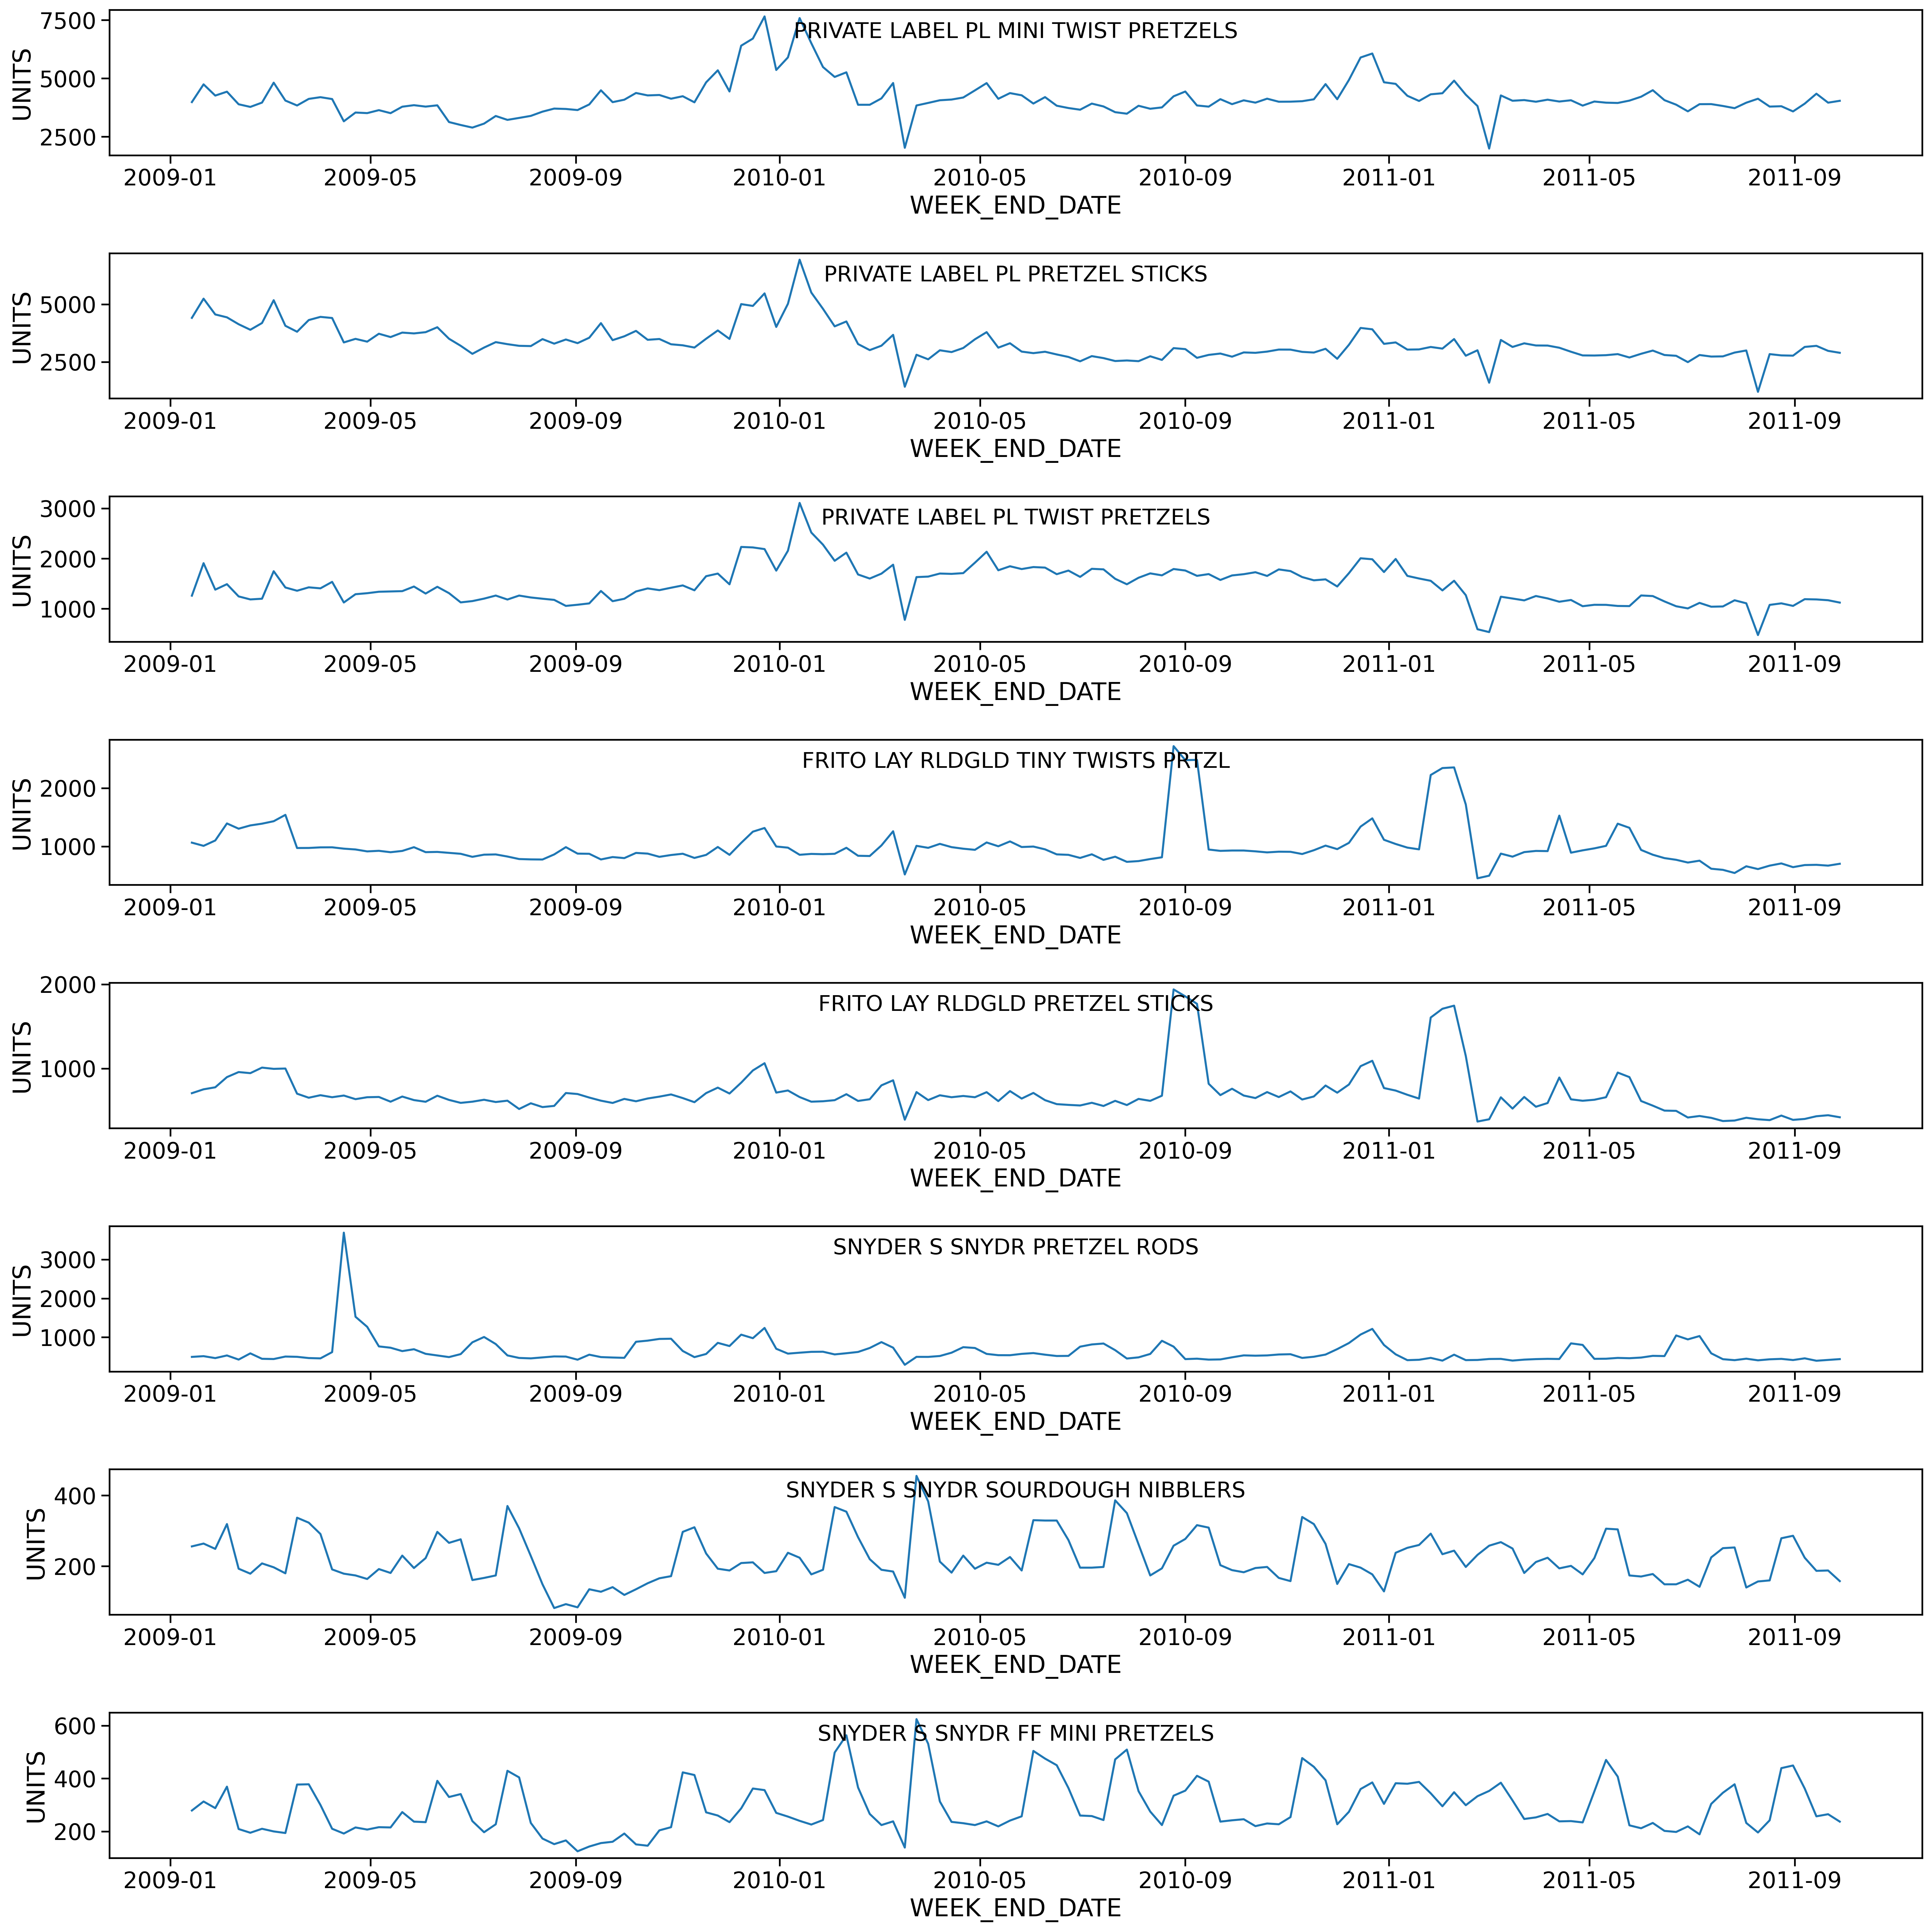

In [104]:
product_plots(pretzels)

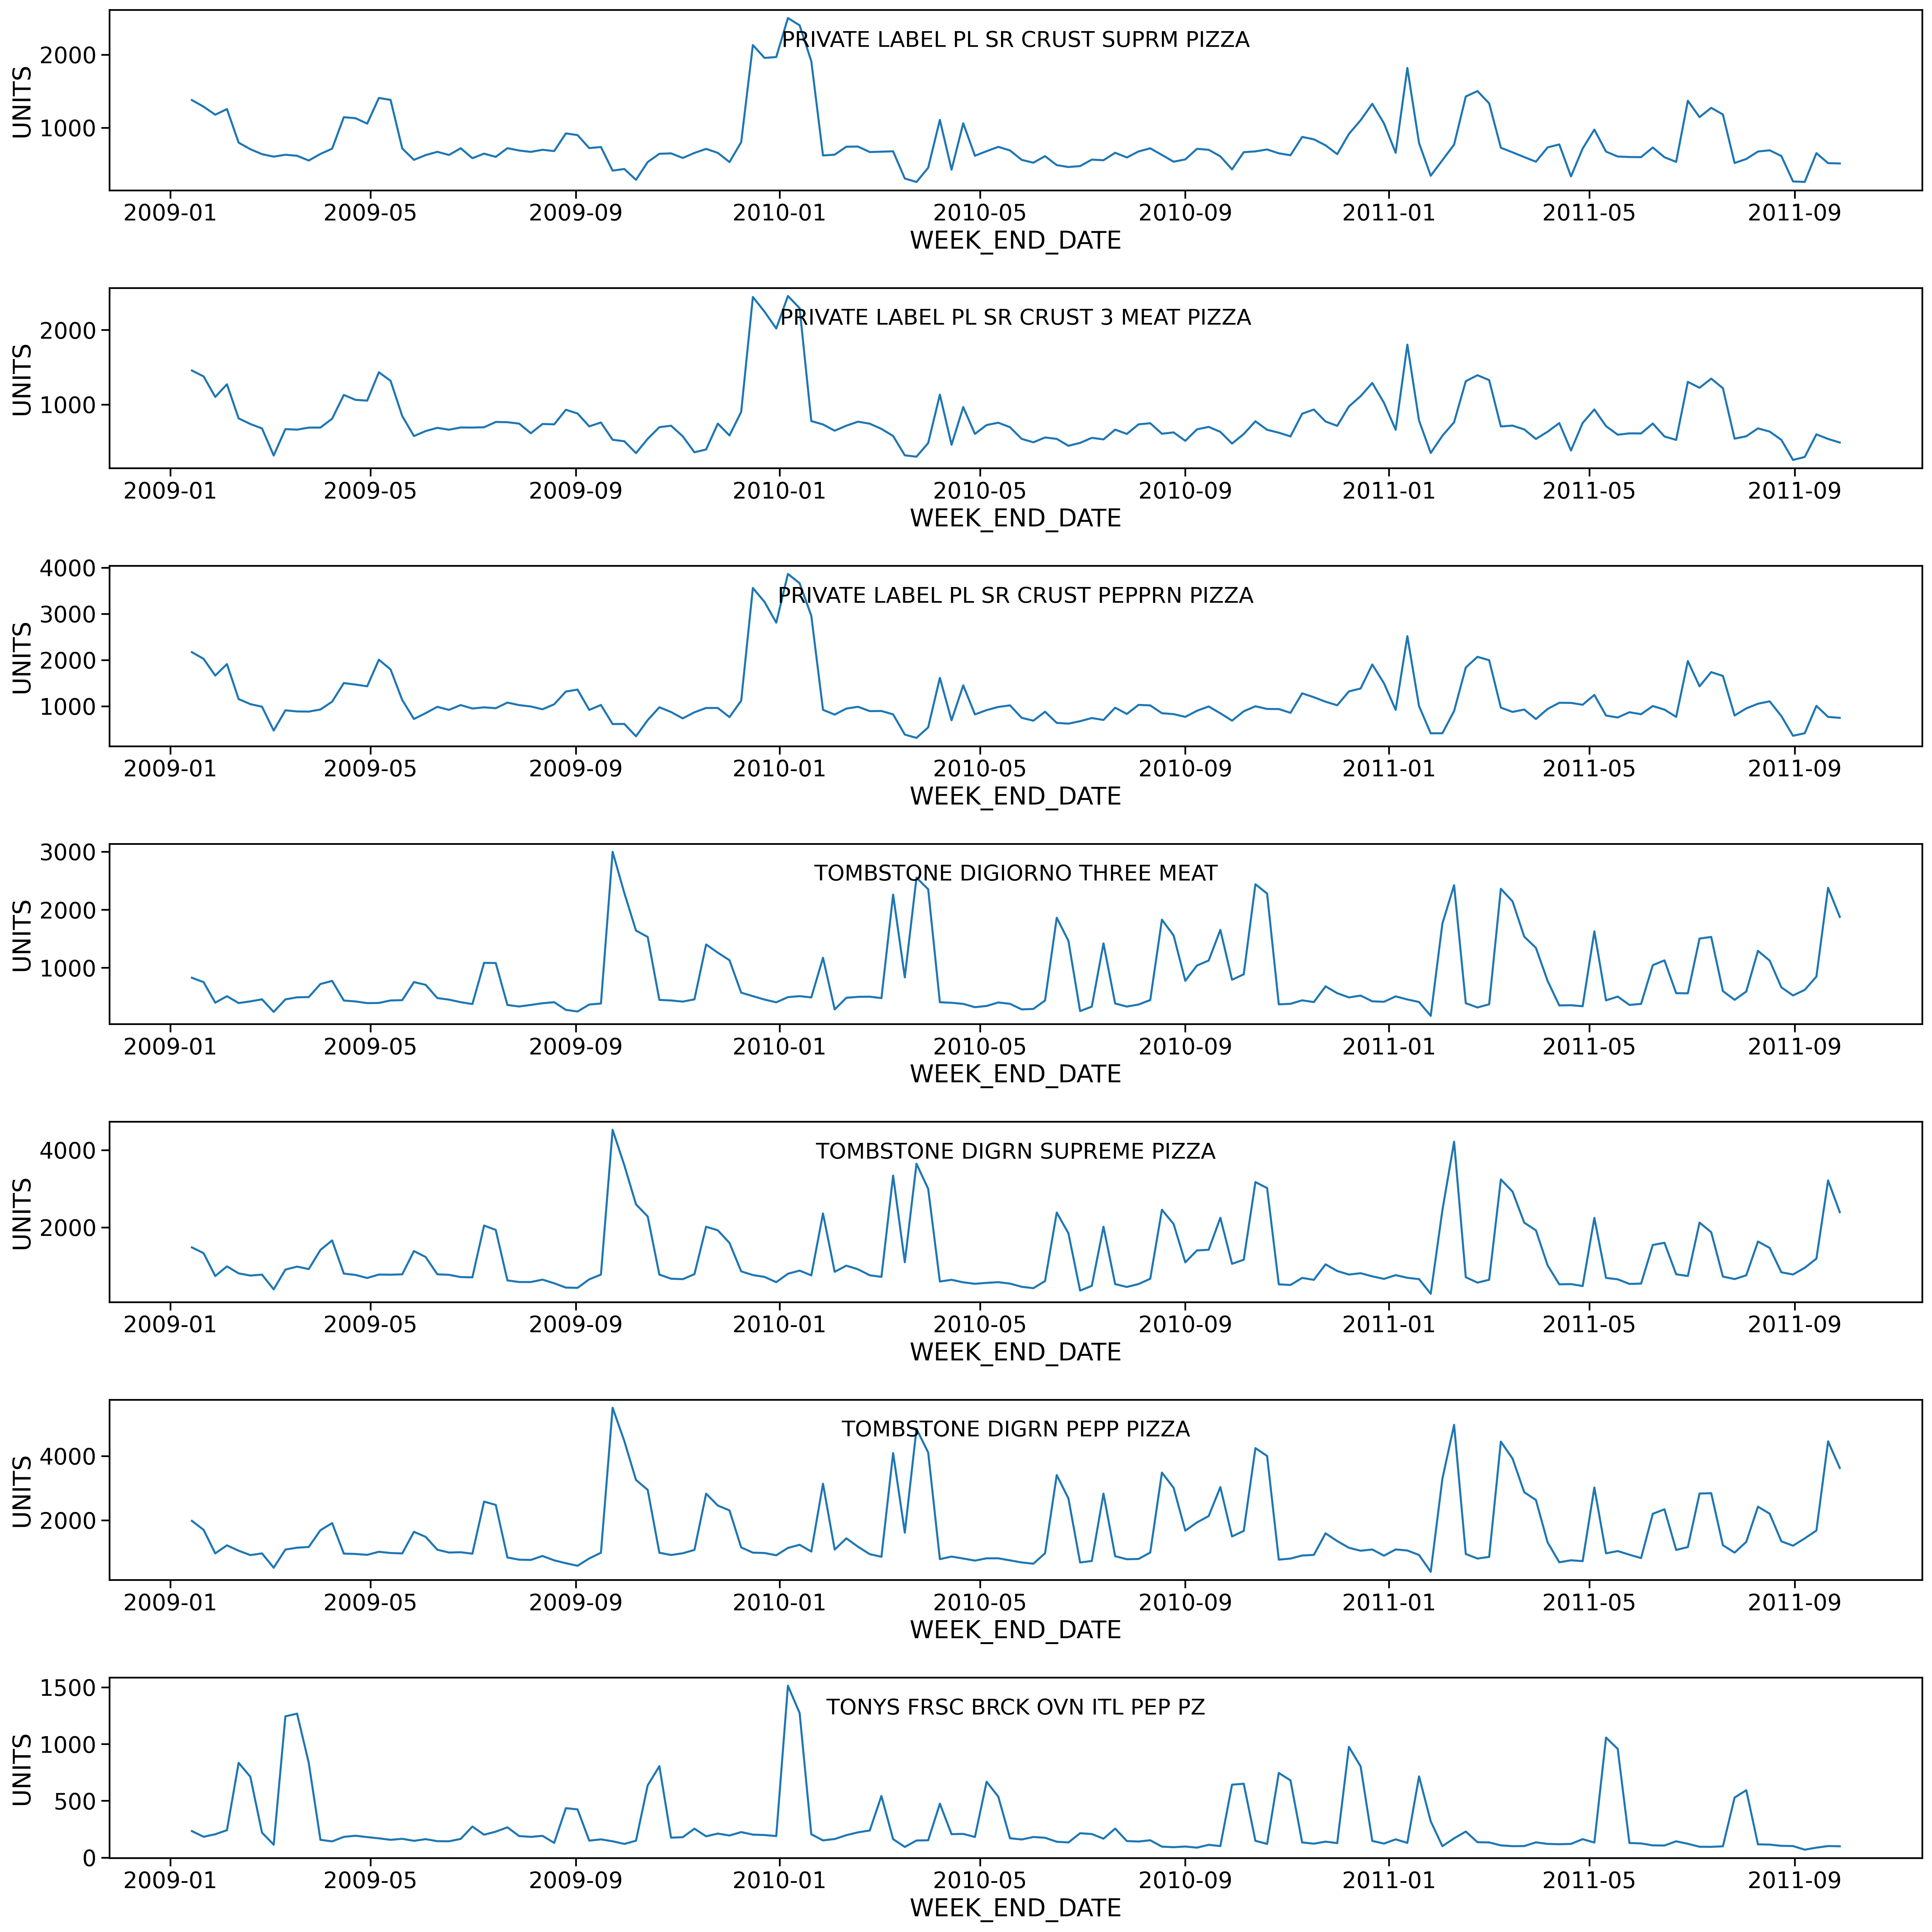

In [105]:
product_plots(frozen_pizza)

- No increasing/decreasing trend for the sale of products over time
- No seasonal patterns seen on individual product sale
- Products by same manufaturer have similar patterns (spikes and drops).


### Units sold per week - at store level
Now, let us look store level demand patterns to see if there are any patterns here.

In [106]:
# Randomly selecting 5 store ID
stores_plot = random.sample(list(store_data['STORE_ID']), 5)

In [107]:
#creating dictionary with store number as keys
# for each store, calculate sum of units sold per week
d = {store: train[train['STORE_NUM'] == store].groupby(['WEEK_END_DATE'])['UNITS'].sum() for store in stores_plot}

<Figure size 2160x720 with 0 Axes>

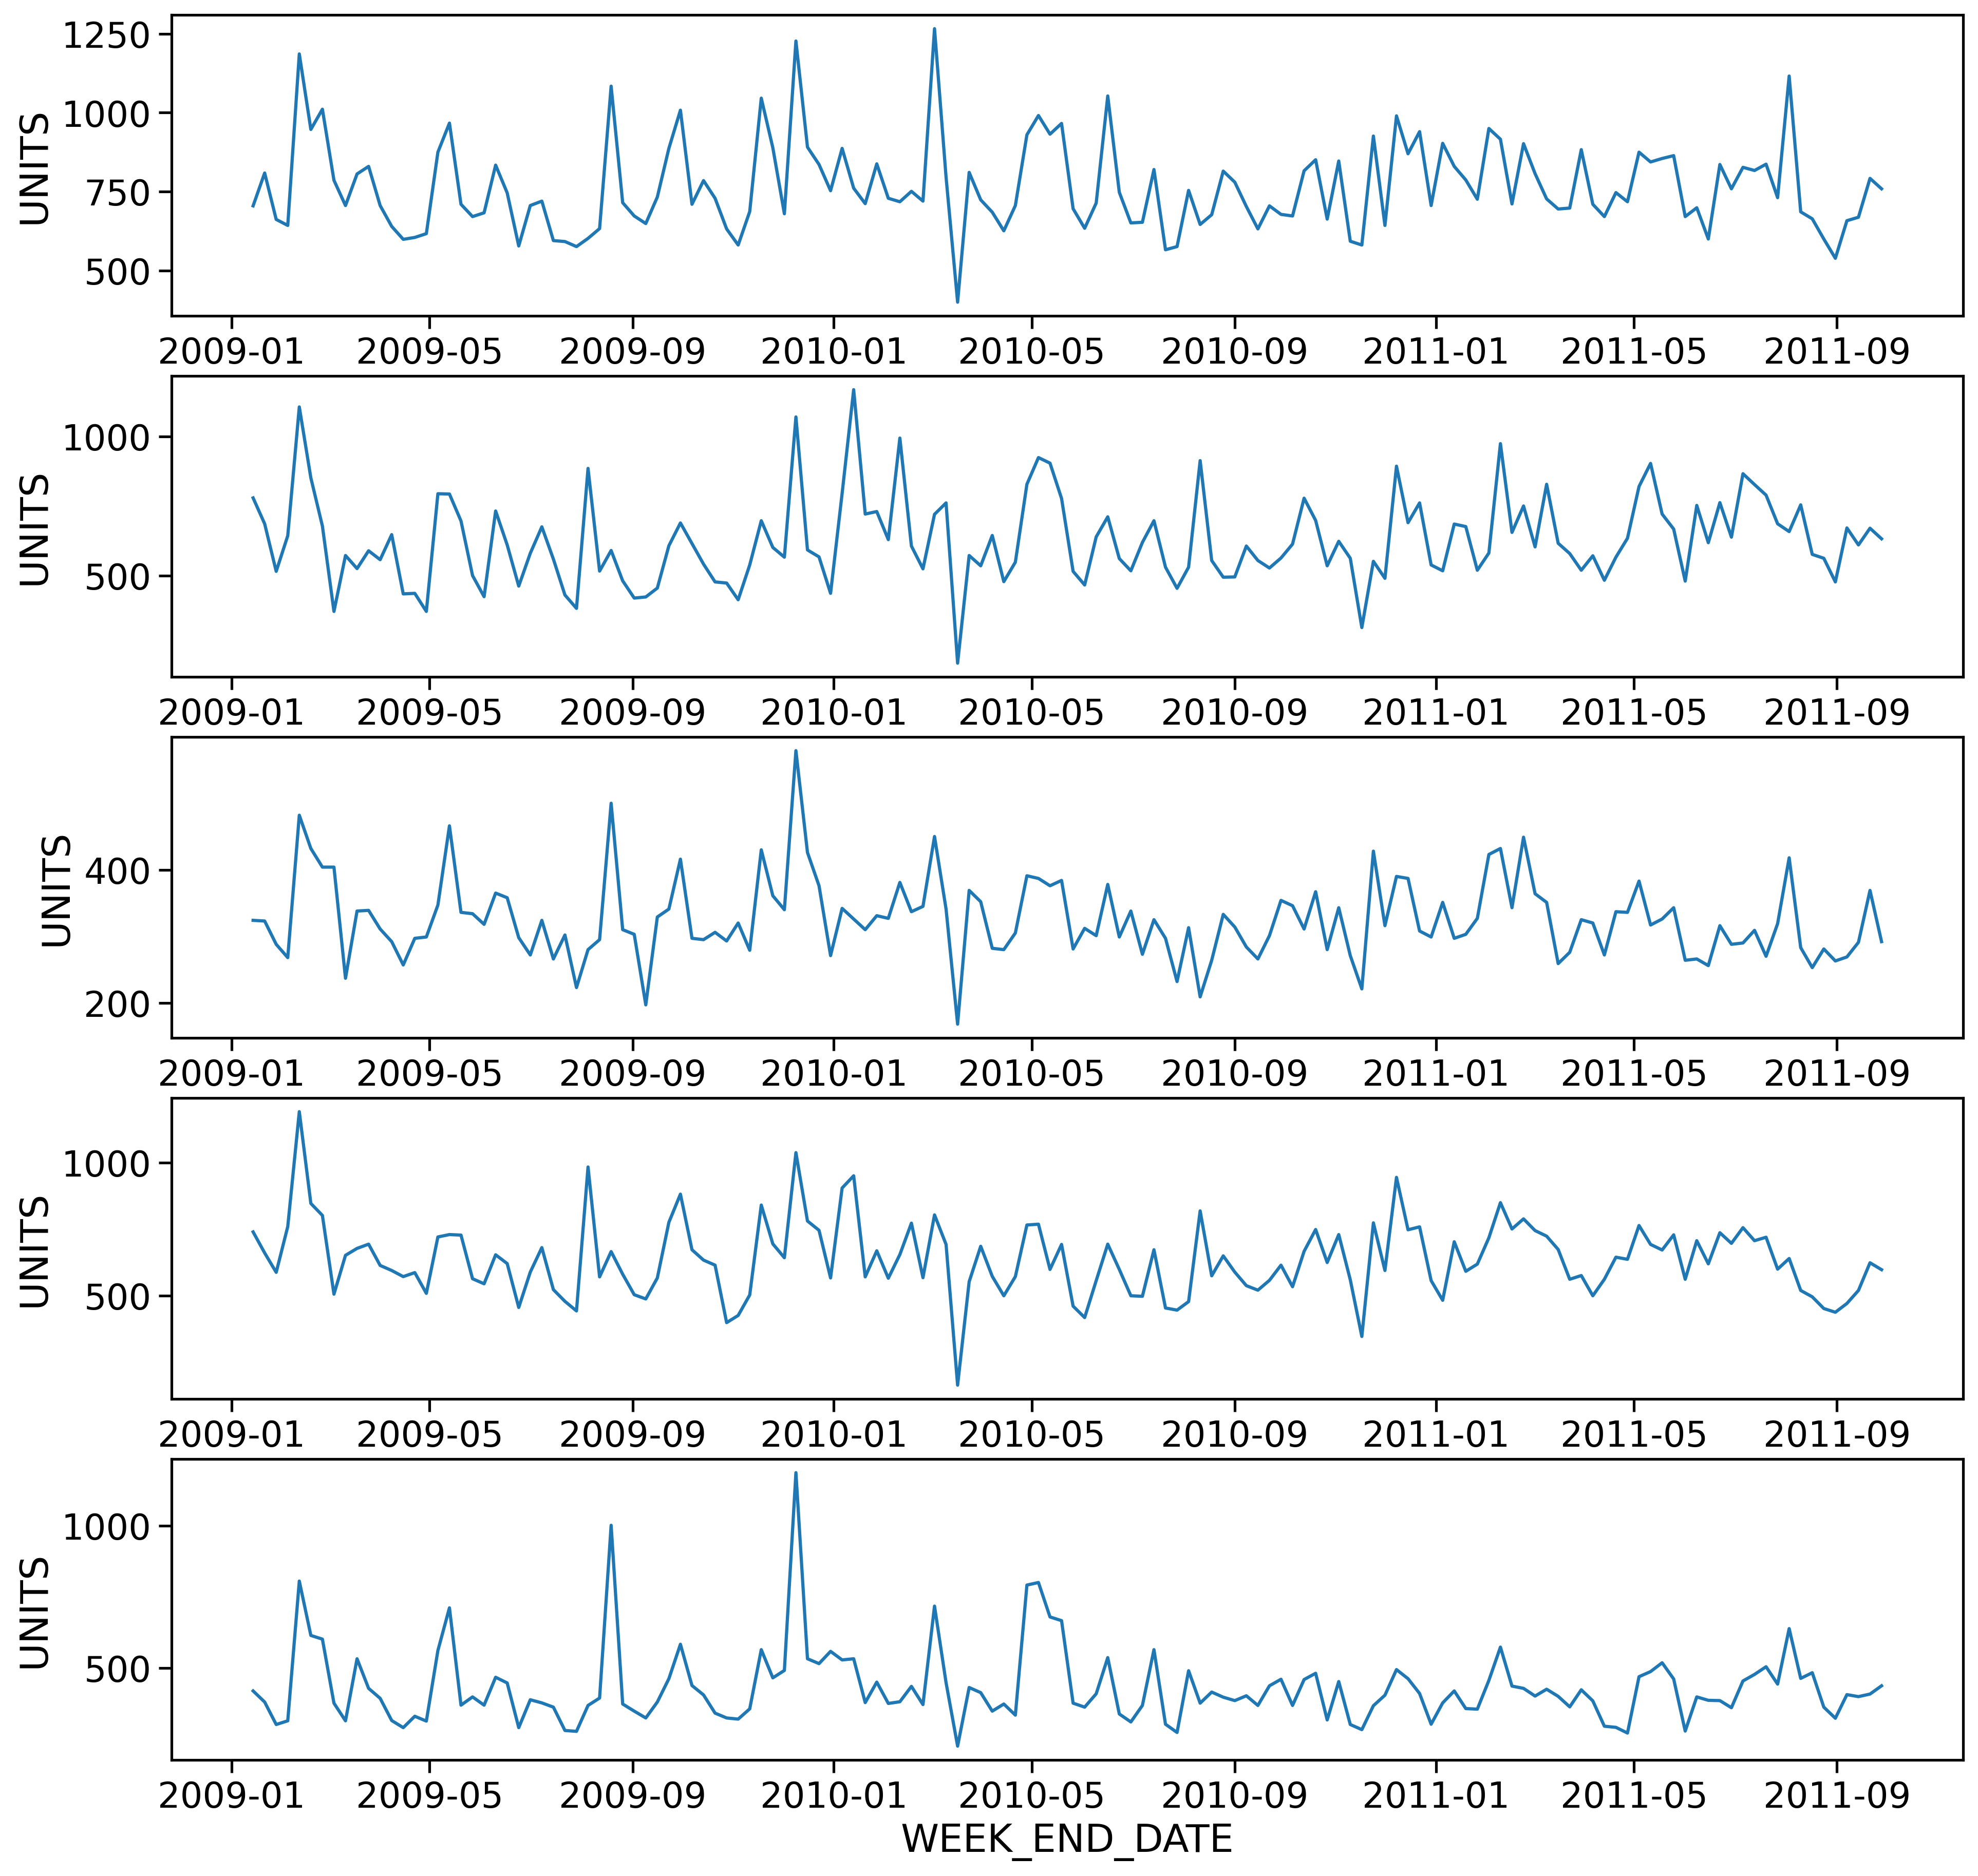

In [108]:
plt.figure(figsize=(30,10))

fig, axs = plt.subplots(5, 1, figsize = (15, 15), dpi=300)
j = 0
for store in d.keys():
    sns.lineplot(x = d[store].index, y = d[store],ax = axs[j])
    j = j+1

For the randomly selected store numbers, we can see that there is no pattern in the plot. The same was repeated for a number of stores and the data showed no increasing or decreasing trend or seasonality. 

#### Are the sudden increase in sales due to product/in-store promotion?

### Featured or Displayed Product have higher sale

- Offer Applicable: Featured Products with attractive offers will have higher sales
- Product Promotion: Sales will be more for products with in-store promotion

In [109]:
def featured_plots(product_list):
    #dictionary storing UPC and 'Featured' variable
    d_f = {product: 1000*train[train['UPC'] == product].groupby(['WEEK_END_DATE'])['FEATURE'].mean() for product in product_list}
    #dictionary storing UPC and Product Sales
    d = {product: train[train['UPC'] == product].groupby(['WEEK_END_DATE'])['UNITS'].sum() for product in product_list}
    
    
    fig, axs = plt.subplots(len(product_list), 1, figsize = (20, 20), dpi=300)
    j = 0
    for product in d.keys():
        # Manufacturer name and Descritption in title
        manu = product_data[product_data['UPC'] == product]['MANUFACTURER'].values[0]
        desc = product_data[product_data['UPC'] == product]['DESCRIPTION'].values[0]
        
        # plotting featured and sales values
        sns.lineplot(x = d_f[product].index, y = d_f[product],ax = axs[j]).set_title(str(manu)+str(" ")+str(desc), y=0.75, fontsize = 16)
        sns.lineplot(x = d[product].index, y = d[product],ax = axs[j]).set_title(str(manu)+str(" ")+str(desc), y=0.75, fontsize = 16)
        j = j+1

In [110]:
product_list_f = list(product_data[product_data['CATEGORY'] == 'BAG SNACKS']['UPC'])

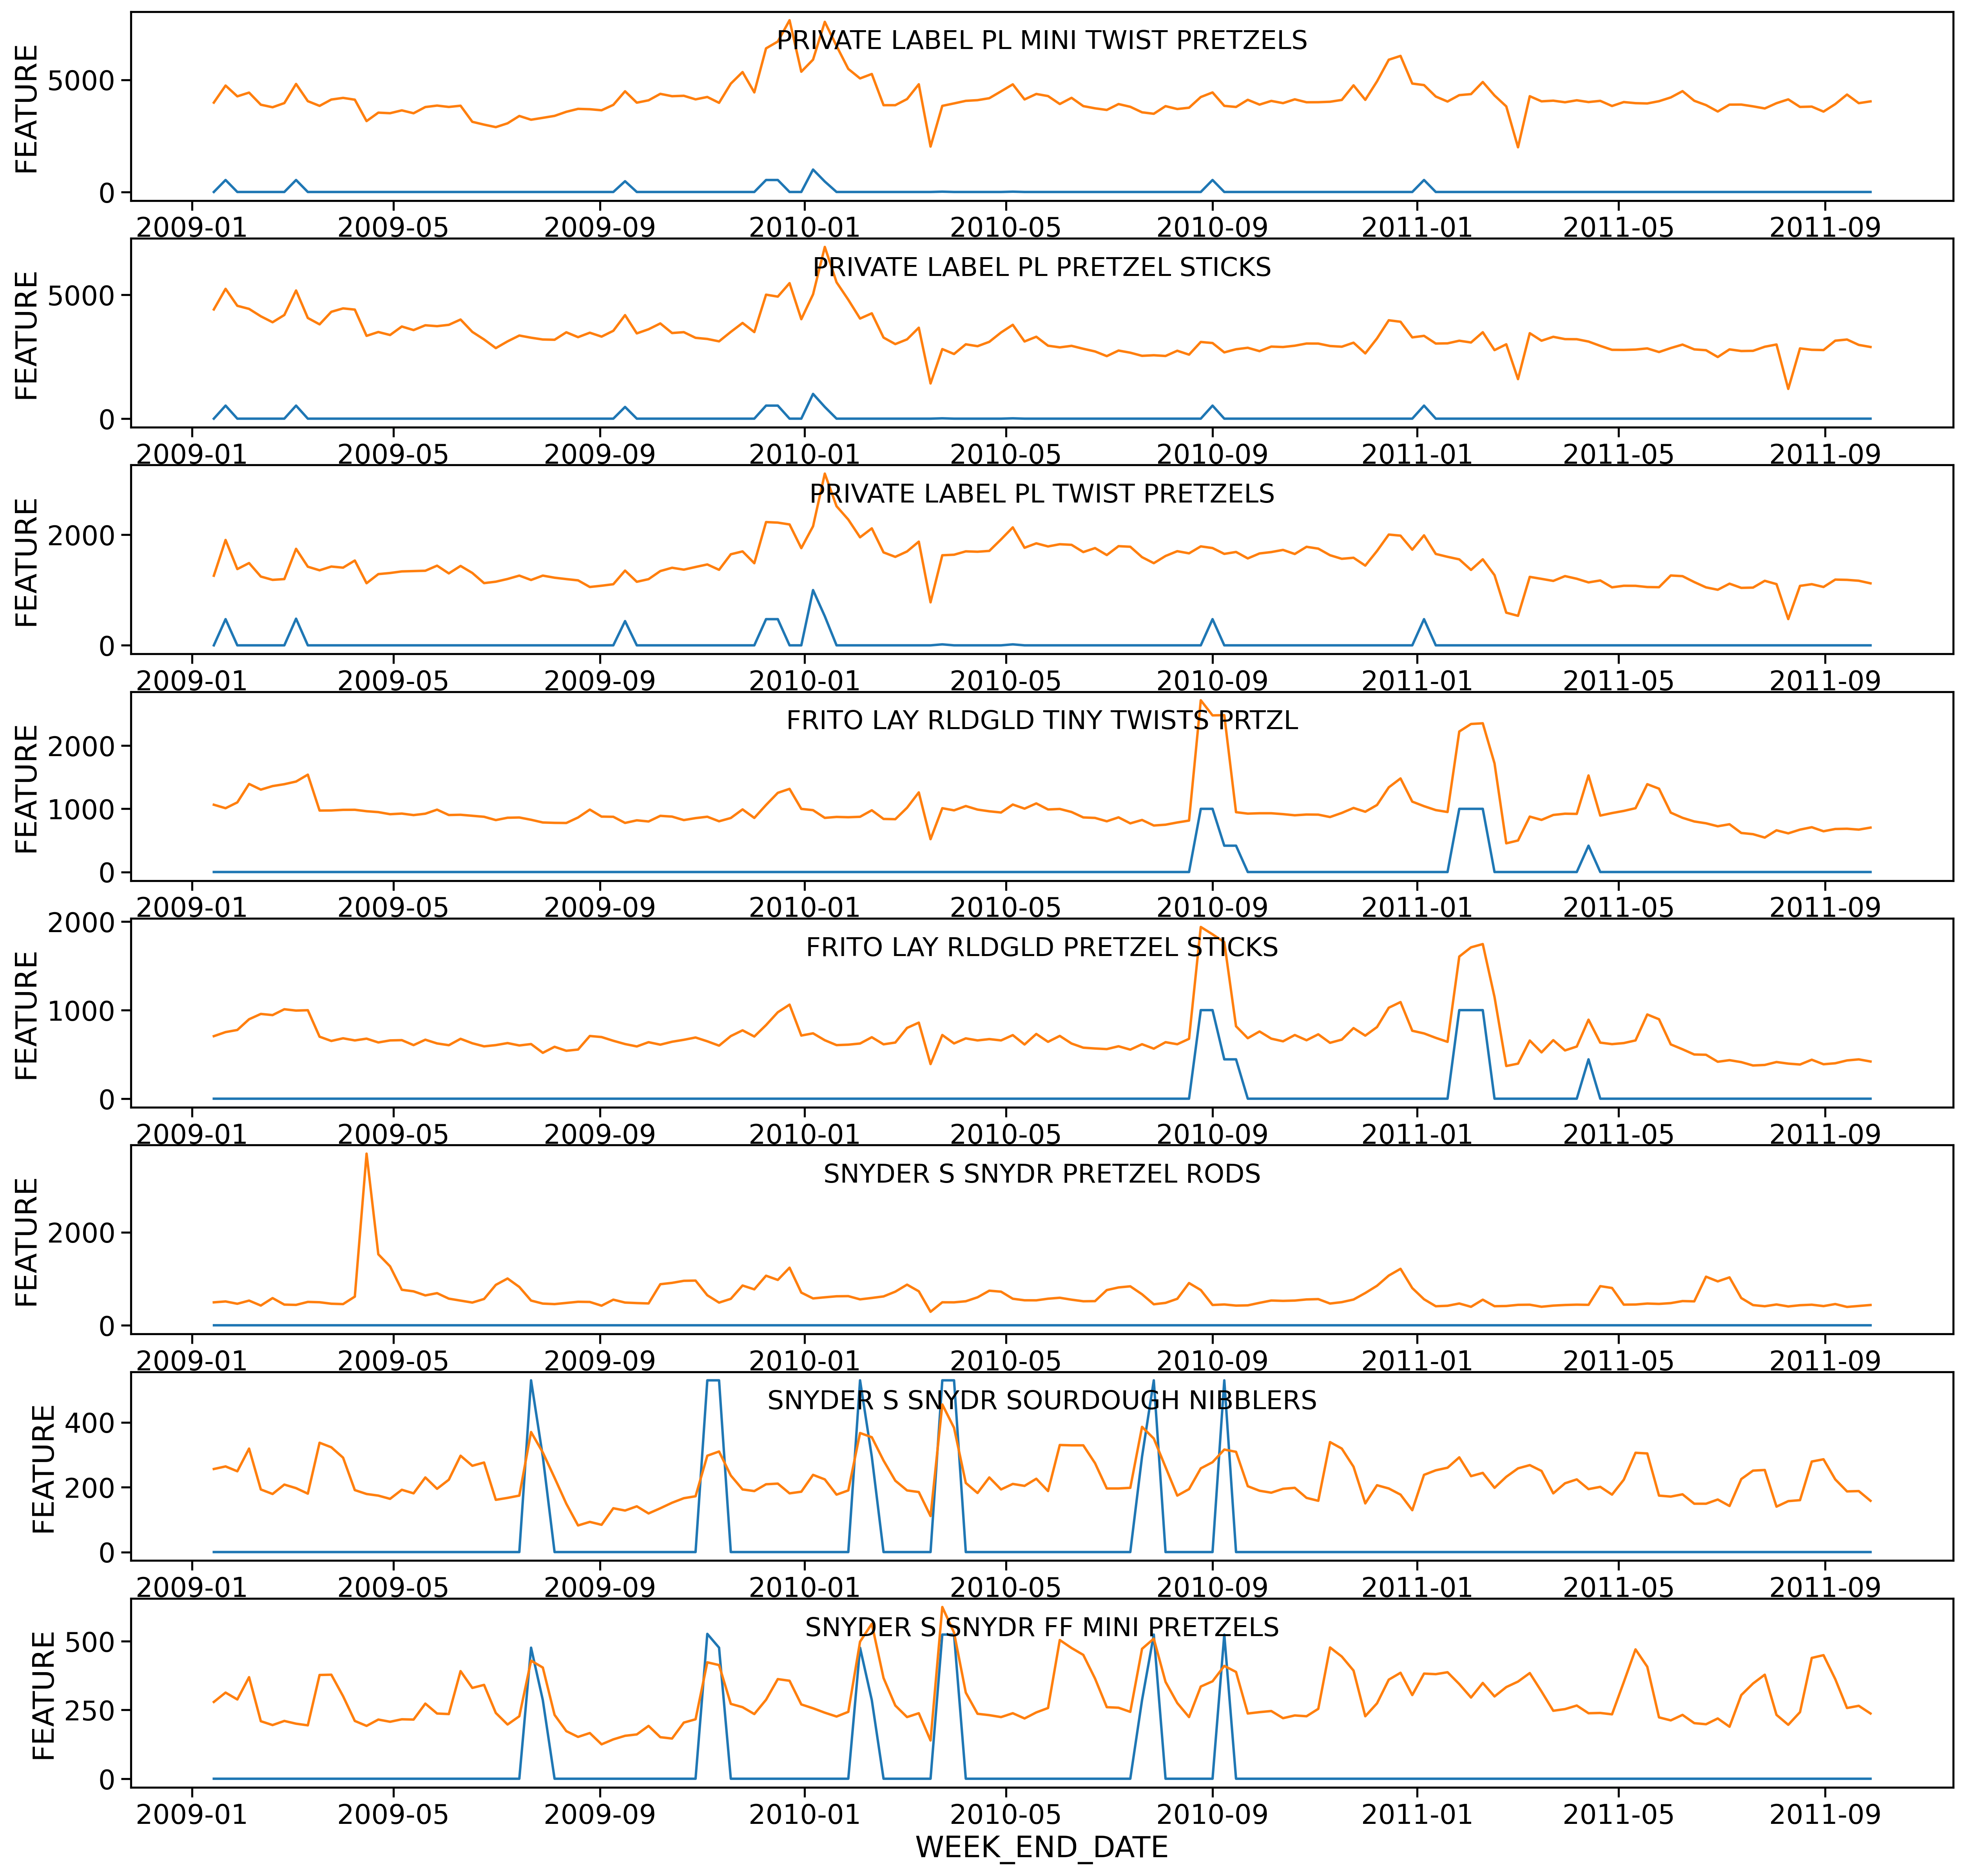

In [111]:
featured_plots(product_list_f)

- When the products are featured, the sales increase.

#### Does the in-store display also have a similar effect?

In [112]:
def display_plots(product_list):
    d_d = {product: 1000*train[train['UPC'] == product].groupby(['WEEK_END_DATE'])['DISPLAY'].mean() for product in product_list}
    d = {product: train[train['UPC'] == product].groupby(['WEEK_END_DATE'])['UNITS'].sum() for product in product_list}
    fig, axs = plt.subplots(len(product_list), 1, figsize = (20, 20), dpi=300)
    j = 0
    for product in d.keys():
        manu = product_data[product_data['UPC'] == product]['MANUFACTURER'].values[0]
        desc = product_data[product_data['UPC'] == product]['DESCRIPTION'].values[0]
        sns.lineplot(x = d[product].index, y = d[product],ax = axs[j]).set_title(str(manu)+str(" ")+str(desc), y=0.75, fontsize = 16)
        sns.lineplot(x = d_d[product].index, y = d_d[product],ax = axs[j]).set_title(str(manu)+str(" ")+str(desc), y=0.75, fontsize = 16)
        j = j+1

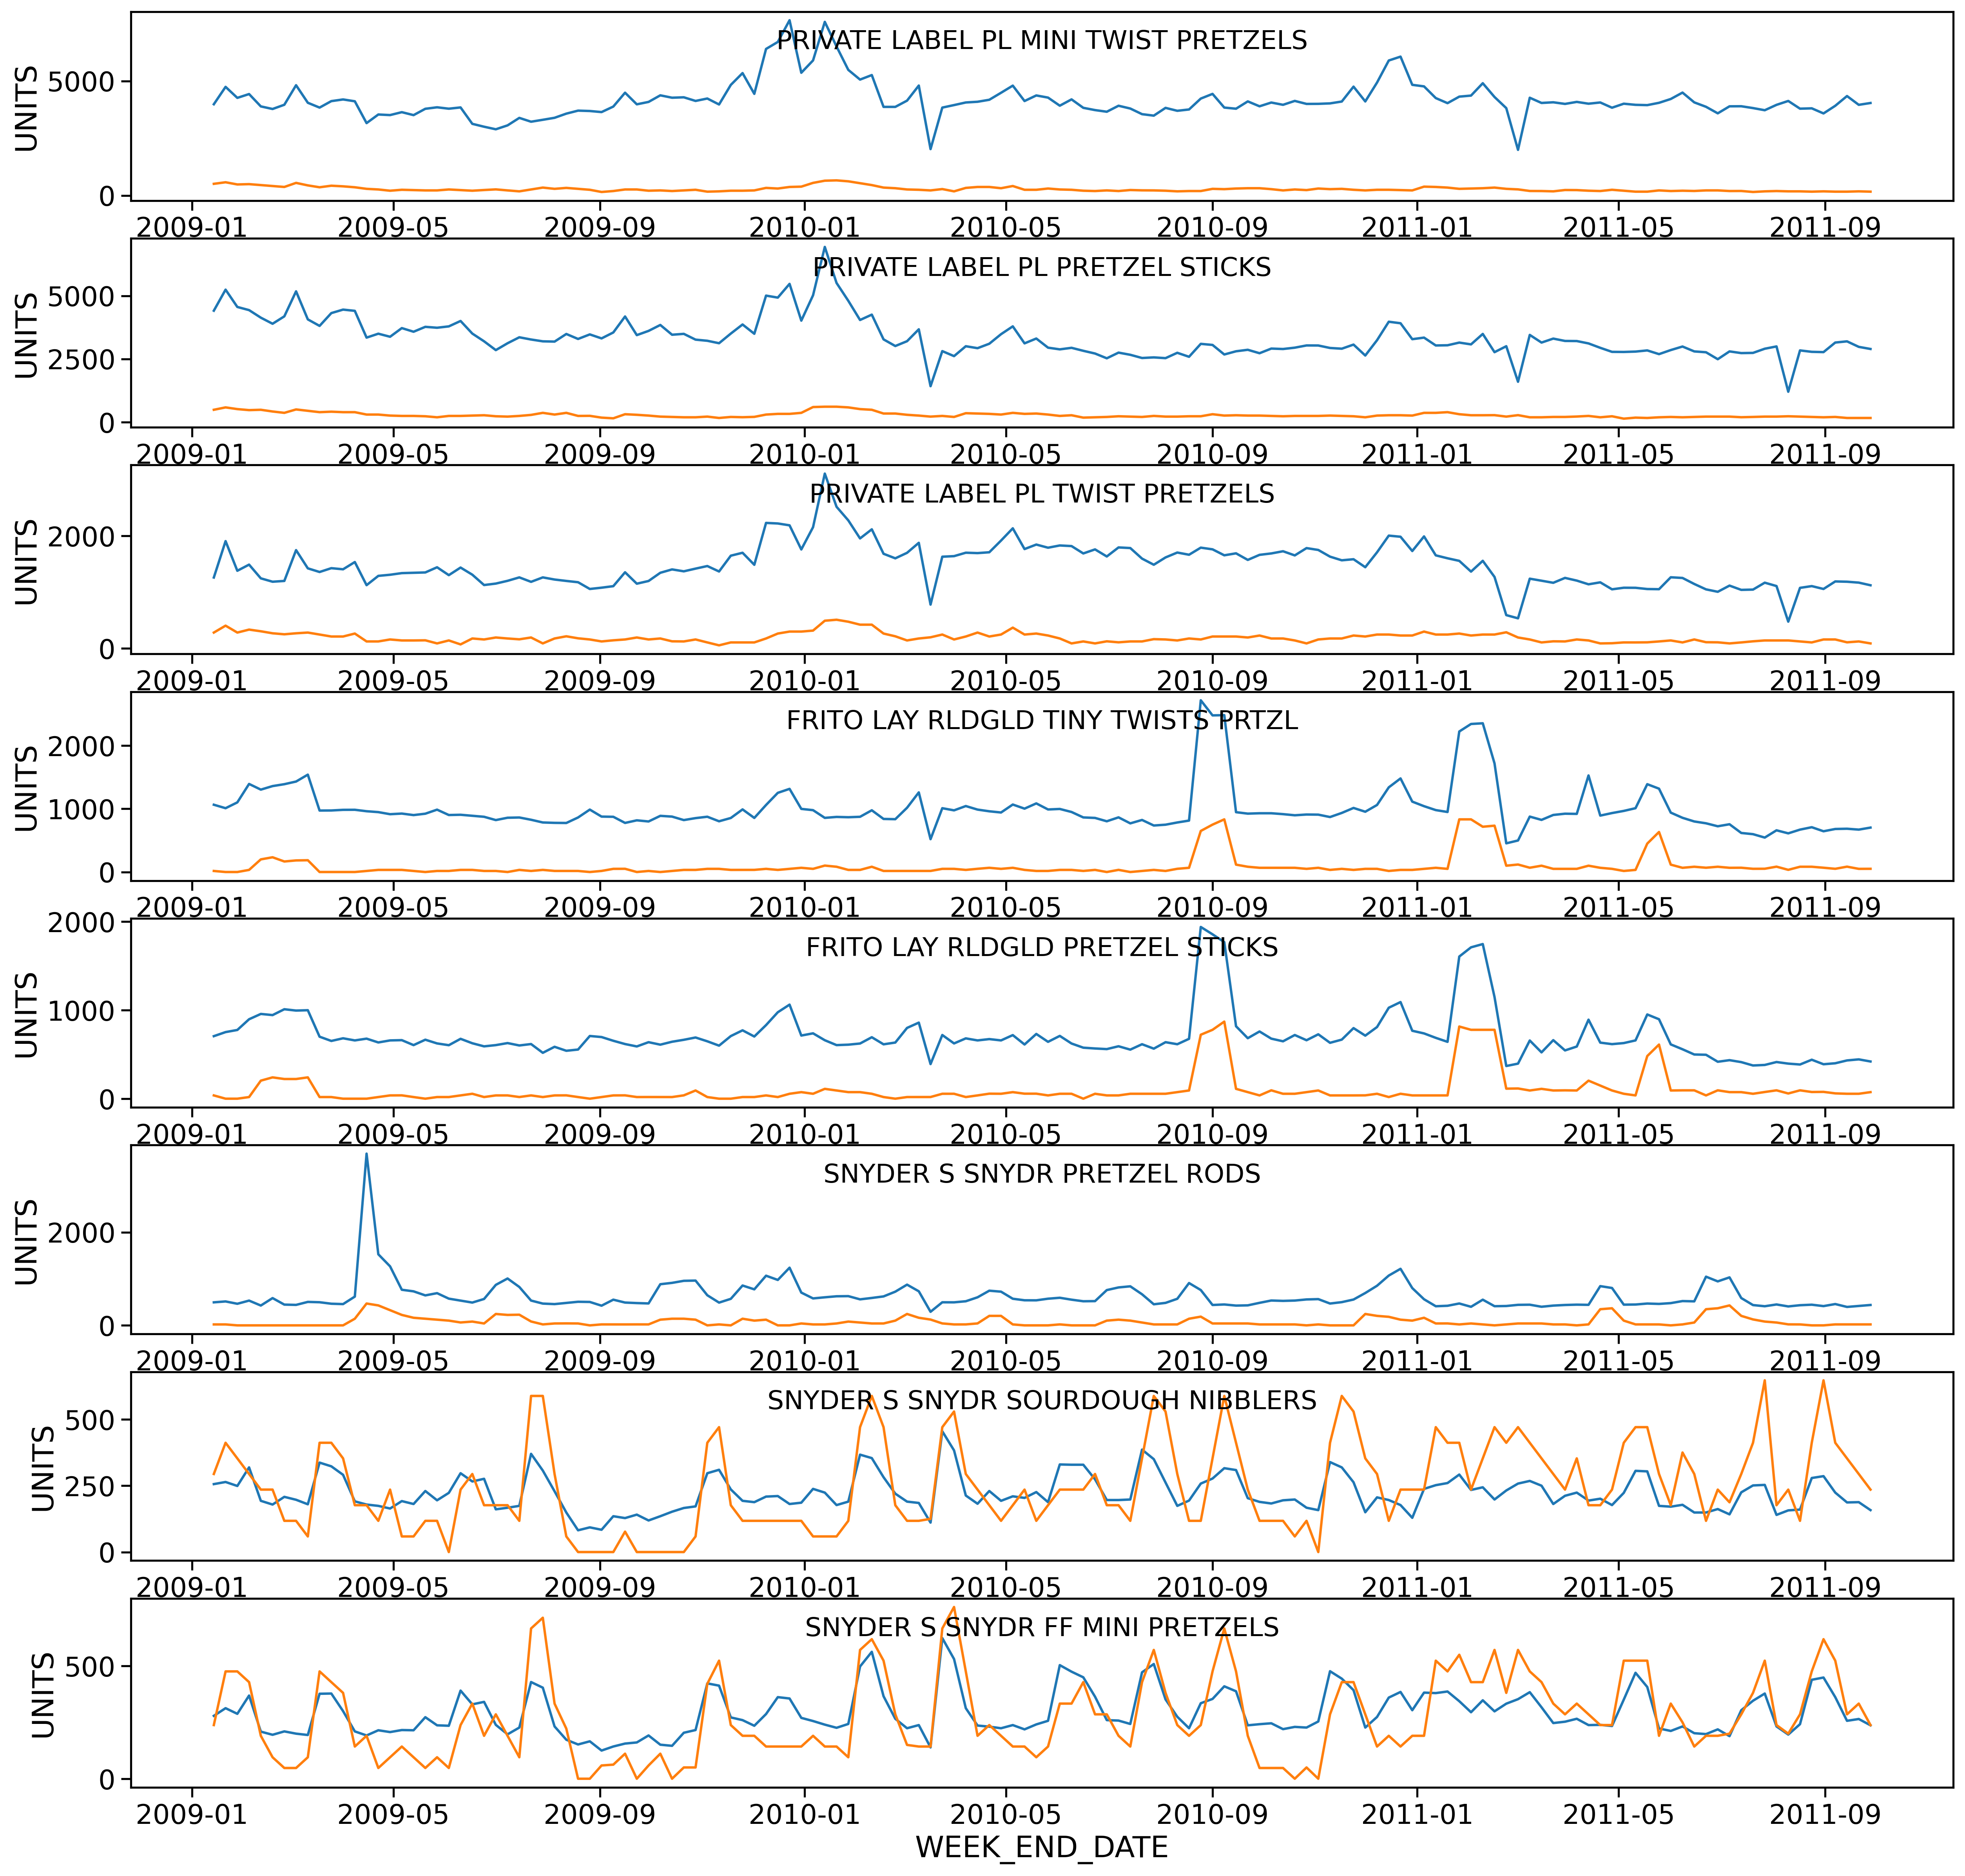

In [113]:
display_plots(product_list_f)

- It is evident that product sales are greatly affected by the display.
- For products on display, the sales are higher.

### Product sales higher for lower priced items

- Price of Product: Same category products with lower price would have more sales


In [114]:
product_size_coldcereal = store_product_data.loc[store_product_data['CATEGORY']=='COLD CEREAL']
product_size_bagsnacks  = store_product_data.loc[store_product_data['CATEGORY']=='BAG SNACKS']
product_size_frozenpizza = store_product_data.loc[store_product_data['CATEGORY']=='FROZEN PIZZA']
product_size_oralhyiegne = store_product_data.loc[store_product_data['CATEGORY']=='ORAL HYGIENE PRODUCTS']

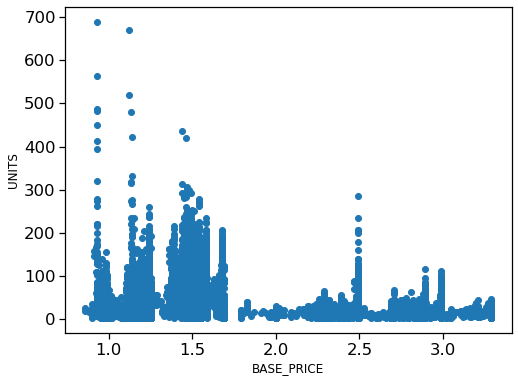

In [115]:
# scatter plot for base price and sales
plt.figure(figsize=(8,6))
plt.scatter(x = (product_size_bagsnacks['BASE_PRICE']), y = (product_size_bagsnacks['UNITS']))
plt.xlabel('BASE_PRICE', fontsize=12)
plt.ylabel('UNITS', fontsize=12)
plt.show()

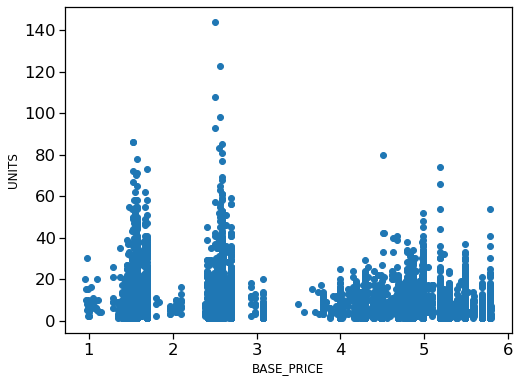

In [116]:
# scatter plot for base price and sales
plt.figure(figsize=(8,6))
plt.scatter(x = (product_size_oralhyiegne['BASE_PRICE']), y = (product_size_oralhyiegne['UNITS']))
plt.xlabel('BASE_PRICE', fontsize=12)
plt.ylabel('UNITS', fontsize=12)
plt.show()

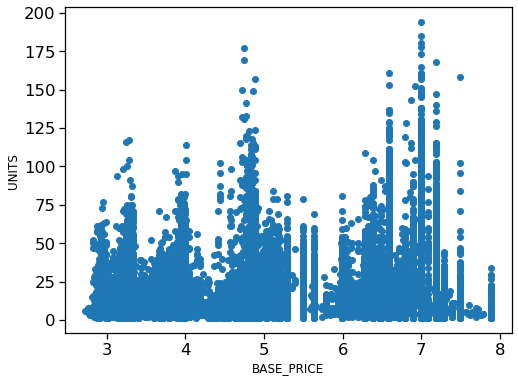

In [117]:
# scatter plot for base price and sales
plt.figure(figsize=(8,6))
plt.scatter(x = (product_size_frozenpizza['BASE_PRICE']), y = (product_size_frozenpizza['UNITS']))
plt.xlabel('BASE_PRICE', fontsize=12)
plt.ylabel('UNITS', fontsize=12)
plt.show()

- For bag snacks and oral hygiene category, items with lower price show a higher sale. 
- Frozen pizza items have higher sale for higher price items.

Check the pattern for cold cereal at your end.

## Product size versus Product Sales

- Product Size : Larger products should be more in demand 


In [118]:
pd.crosstab(product_size_coldcereal['CATEGORY'], product_size_coldcereal['PRODUCT_SIZE'])

PRODUCT_SIZE  12 OZ  12.2 OZ  12.25 OZ  15 OZ  18 OZ  20 OZ
CATEGORY                                                   
COLD CEREAL   10786    10766     21426  10785  32203  10789

In [119]:
pd.crosstab(product_size_bagsnacks['CATEGORY'], product_size_bagsnacks['PRODUCT_SIZE'])

PRODUCT_SIZE  10 OZ  15 OZ  16 OZ
CATEGORY                         
BAG SNACKS     6916  28921  21443

#### Is the product sale higher for a particular brand or manufacturer?

## Product sales for different manufacturers

- Company/ Manufacturer: Well known brands/manufacturers will have higher sales


In [120]:
pretzels = list(product_data[product_data['CATEGORY'] == 'BAG SNACKS']['UPC'])
frozen_pizza = list(product_data[product_data['CATEGORY'] == 'FROZEN PIZZA']['UPC'])
oral_hygiene = list(product_data[product_data['CATEGORY'] == 'ORAL HYGIENE PRODUCTS']['UPC'])
cold_cereal = list(product_data[product_data['CATEGORY'] == 'COLD CEREAL']['UPC'])

UPC               DESCRIPTION   MANUFACTURER    CATEGORY  \
0   1111009477    PL MINI TWIST PRETZELS  PRIVATE LABEL  BAG SNACKS   
1   1111009497         PL PRETZEL STICKS  PRIVATE LABEL  BAG SNACKS   
2   1111009507         PL TWIST PRETZELS  PRIVATE LABEL  BAG SNACKS   
14  2840004768  RLDGLD TINY TWISTS PRTZL      FRITO LAY  BAG SNACKS   
15  2840004770     RLDGLD PRETZEL STICKS      FRITO LAY  BAG SNACKS   
25  7797502248        SNYDR PRETZEL RODS       SNYDER S  BAG SNACKS   
26  7797508004  SNYDR SOURDOUGH NIBBLERS       SNYDER S  BAG SNACKS   
27  7797508006    SNYDR FF MINI PRETZELS       SNYDER S  BAG SNACKS   

   SUB_CATEGORY PRODUCT_SIZE  
0      PRETZELS        15 OZ  
1      PRETZELS        15 OZ  
2      PRETZELS        15 OZ  
14     PRETZELS        16 OZ  
15     PRETZELS        16 OZ  
25     PRETZELS        10 OZ  
26     PRETZELS        16 OZ  
27     PRETZELS        16 OZ

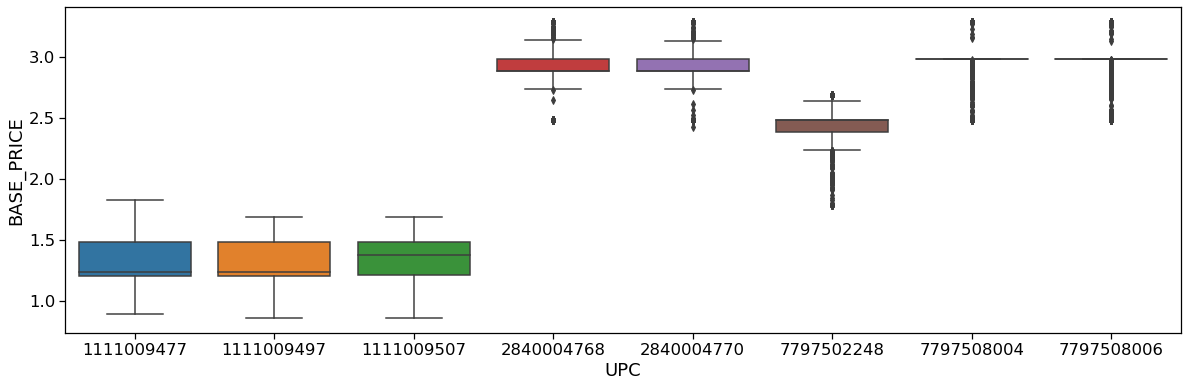

In [121]:
plt.figure(figsize=(20,6))
ax = sns.boxplot(x="UPC", y="BASE_PRICE", data=train[train['UPC'].isin(pretzels)])
product_data[product_data['UPC'].isin(pretzels)]

- All Private Label snacks have lower price. 
- The Snyder S bag snacks with a smaller size has a lower price.

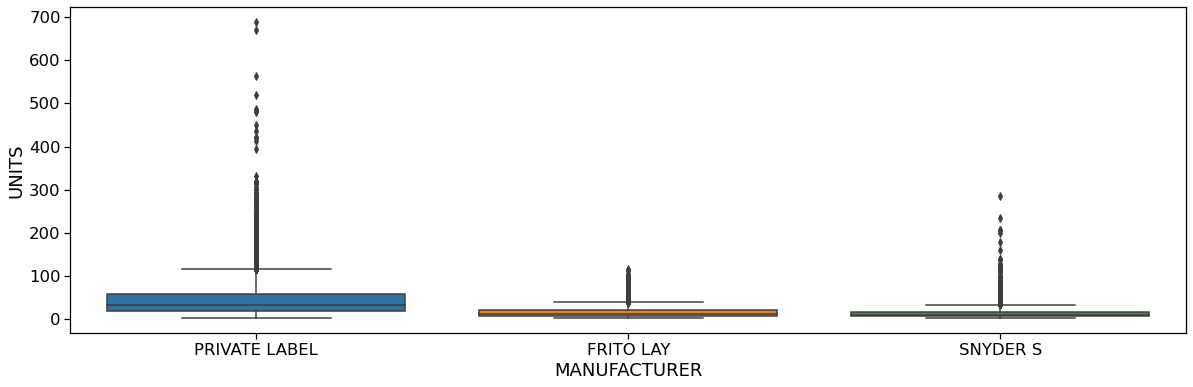

In [122]:
plt.figure(figsize=(20,6))
ax = sns.boxplot(x="MANUFACTURER", y="UNITS", data=store_product_data[store_product_data['UPC'].isin(pretzels)])

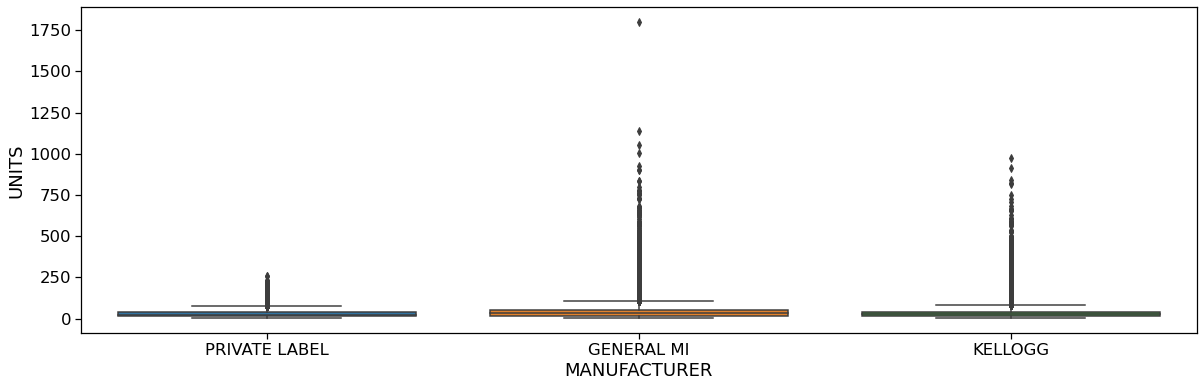

In [123]:
plt.figure(figsize=(20,6))
ax = sns.boxplot(x="MANUFACTURER", y="UNITS", data=store_product_data[store_product_data['UPC'].isin(cold_cereal)])

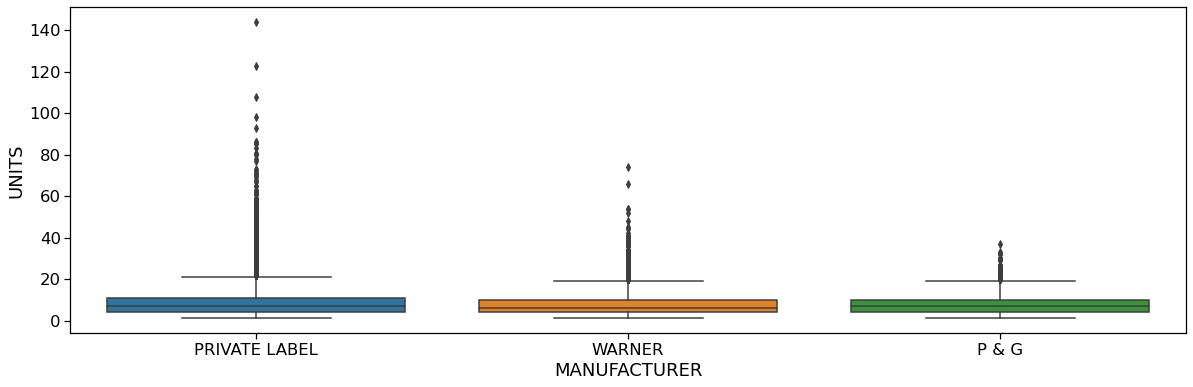

In [124]:
plt.figure(figsize=(20,6))
ax = sns.boxplot(x="MANUFACTURER", y="UNITS", data=store_product_data[store_product_data['UPC'].isin(oral_hygiene)])

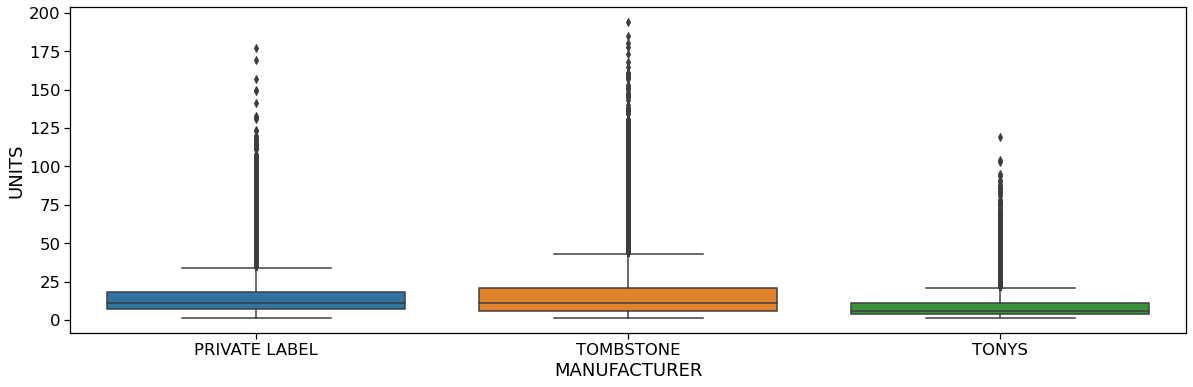

In [125]:
plt.figure(figsize=(20,6))
ax = sns.boxplot(x="MANUFACTURER", y="UNITS", data=store_product_data[store_product_data['UPC'].isin(frozen_pizza)])

#### Is there a significant difference in the product sales for different regions?

#### How are the sales different for stores in different cities?

## Unit Sales for Stores in Different States

- Store Location: Stores in a particular state/city will have a similar trend

In [126]:
grouped_weekly_sales = store_product_data.groupby(['WEEK_END_DATE','STORE_NUM'])['UNITS'].sum().reset_index()

grouped_weekly_sales = grouped_weekly_sales.merge(store_data, how = 'left', left_on = 'STORE_NUM', right_on = 'STORE_ID')

grouped_weekly_sales = grouped_weekly_sales.sort_values(by = 'ADDRESS_STATE_PROV_CODE')

In [127]:
state = (store_data[['ADDRESS_STATE_PROV_CODE','STORE_ID']].sort_values(by ='ADDRESS_STATE_PROV_CODE'))['STORE_ID']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75]),
 [Text(0, 0, '4245'),
  Text(1, 0, '19265'),
  Text(2, 0, '367'),
  Text(3, 0, '11757'),
  Text(4, 0, '389'),
  Text(5, 0, '13609'),
  Text(6, 0, '15531'),
  Text(7, 0, '28909'),
  Text(8, 0, '15547'),
  Text(9, 0, '21213'),
  Text(10, 0, '21221'),
  Text(11, 0, '21227'),
  Text(12, 0, '21237'),
  Text(13, 0, '26981'),
  Text(14, 0, '11761'),
  Text(15, 0, '23061'),
  Text(16, 0, '23067'),
  Text(17, 0, '23075'),
  Text(18, 0, '24991'),
  Text(19, 0, '25001'),
  Text(20, 0, '25021'),
  Text(21, 0, '25027'),
  Text(22, 0, '26973'),
  Text(23, 0, '26983'),
  Text(24, 0, '23055'),
  Text(25, 0, '15541'),
  Text(26, 0, '9825'),
  Text(27, 0, '6179'),

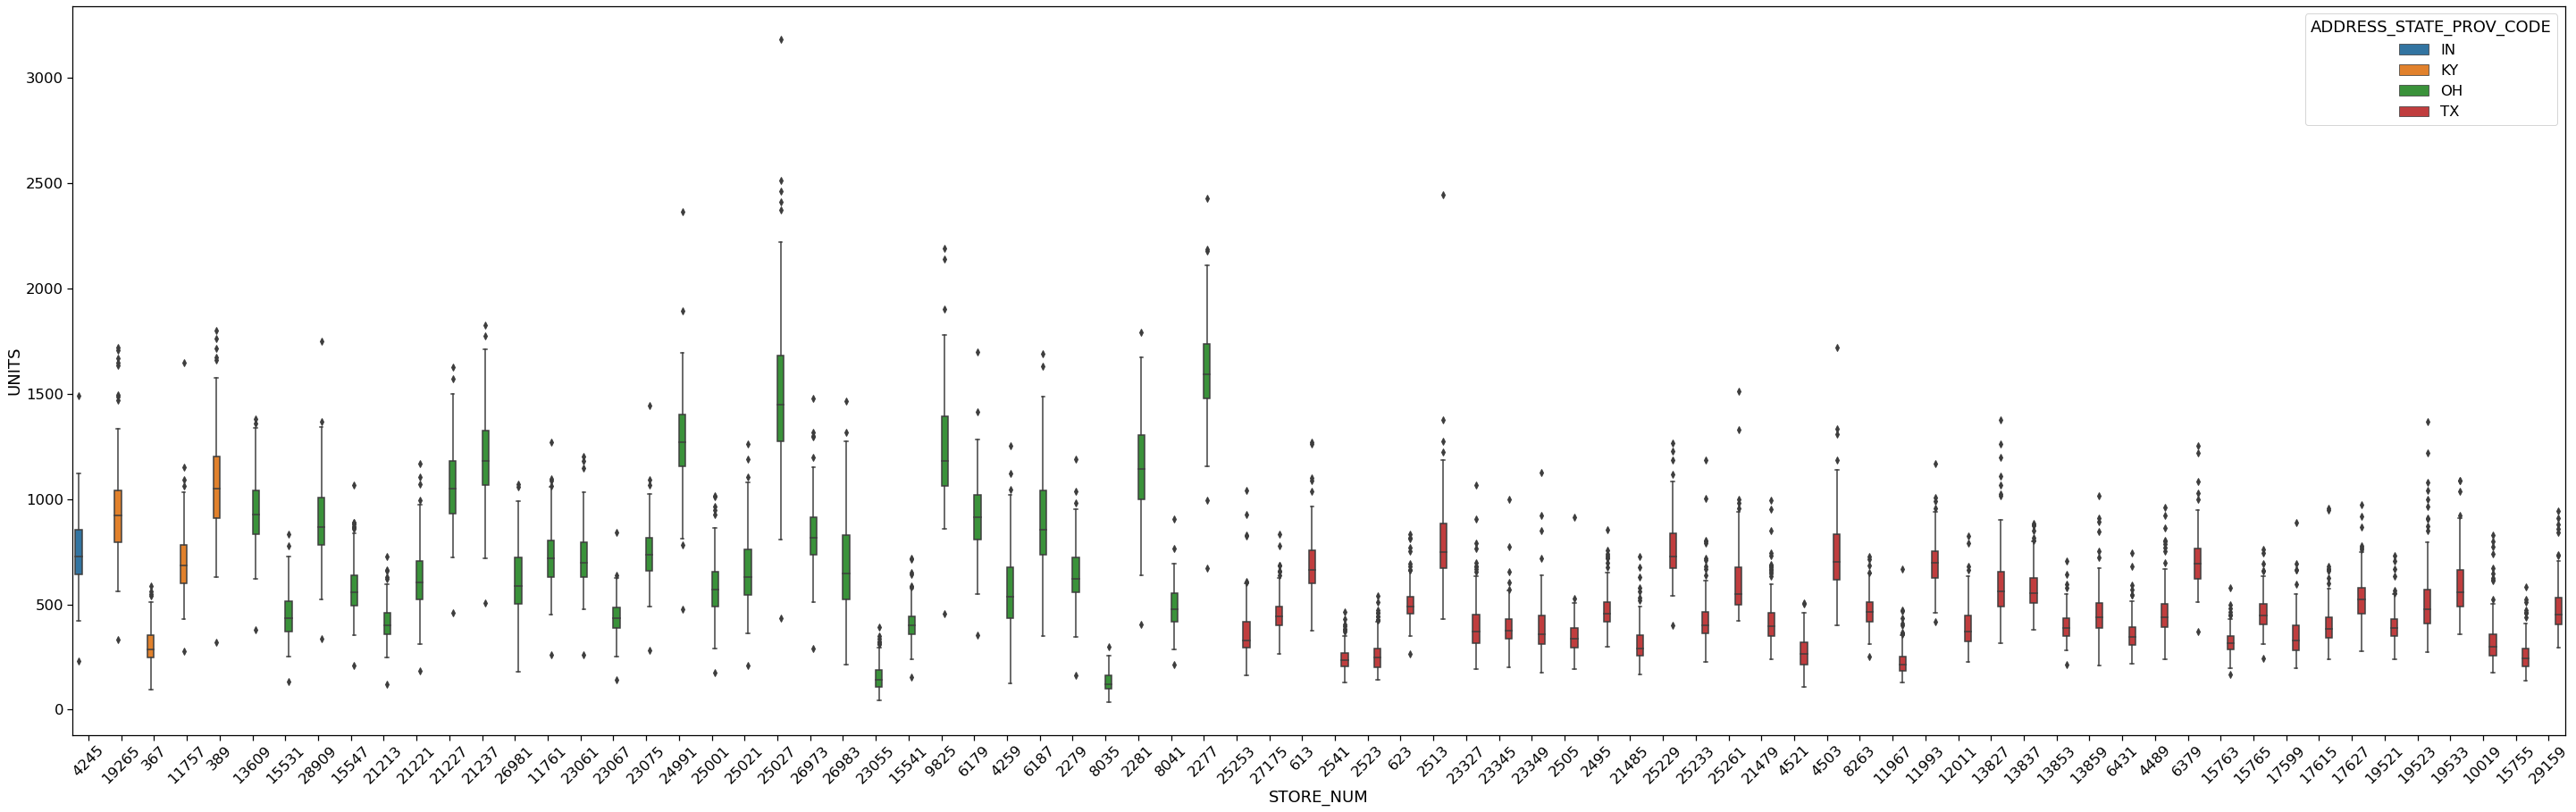

In [128]:
plt.figure(figsize=(50,15))

ax=sns.boxplot(x="STORE_NUM",y="UNITS",data=grouped_weekly_sales, hue ='ADDRESS_STATE_PROV_CODE', order =state)
plt.xticks(rotation=45)

- The most frequent colors we see are green and orange - Ohio and Texas
- Mostly the number of units is higher for Ohio (considering individual stores)

## Store Size and unit sales

- Size of Store: Stores with larger area would have more sales

In [129]:
store_agg_data = train.groupby(['STORE_NUM'])['UNITS'].sum().reset_index()
merged_store_data = store_data.merge(store_agg_data, how = 'left', left_on = 'STORE_ID', right_on = 'STORE_NUM')

<AxesSubplot:xlabel='SALES_AREA_SIZE_NUM', ylabel='Density'>

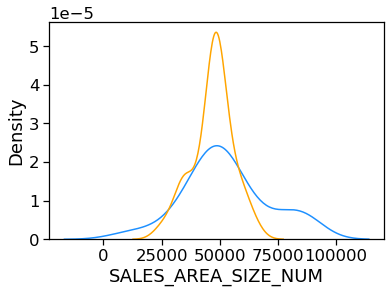

In [130]:
state_oh = merged_store_data.loc[merged_store_data['ADDRESS_STATE_PROV_CODE'] == 'OH']
state_tx = merged_store_data.loc[merged_store_data['ADDRESS_STATE_PROV_CODE'] == 'TX']

sns.distplot(state_oh['SALES_AREA_SIZE_NUM'], hist=False,color= 'dodgerblue', label= 'OHIO')
sns.distplot(state_tx['SALES_AREA_SIZE_NUM'], hist=False,  color= 'orange', label= 'TEXAS')


<AxesSubplot:xlabel='SALES_AREA_SIZE_NUM', ylabel='UNITS'>

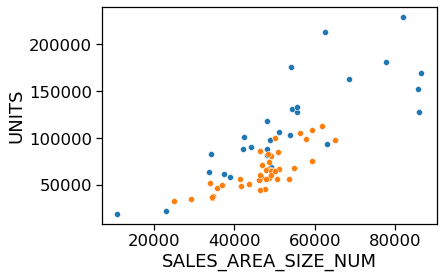

In [131]:
sns.scatterplot(x = (state_oh['SALES_AREA_SIZE_NUM']), y = (state_oh['UNITS']))
sns.scatterplot(x = (state_tx['SALES_AREA_SIZE_NUM']), y = (state_tx['UNITS']))

##### Assignment Question 1:  Does the 'Display' have more impact on demand than 'Feature' or other way round ?

**Ans**
- a) When the products are featured, the sales increase
- b) It is evident that product sales are greatly affected by the display.For products on display, the sales are higher.

##### Assignment Question 2:  Does the number of unique manufacturers for a category & sub category ( Bag snacks, Frozen pizza etc) impact the demand ?